In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import dash
from dash import dcc, html
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Bidirectional, Flatten, Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,GRU,BatchNormalization
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from plotly.subplots import make_subplots
import json
import plotly.io as pio

In [6]:
#Get the ticker symbols for Apple, Microsoft and Google
apple = yf.download('AAPL', start="2009-01-01", end="2023-12-31")
google =yf.download("MSFT", start="2009-01-01", end="2023-12-31")
microsoft =yf.download("GOOGL", start="2009-01-01", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
#View the data
apple.head()

Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2009-01-02  3.067143  3.251429  3.041429  3.241071   2.737004   746015200
2009-01-05  3.327500  3.435000  3.311071  3.377857   2.852516  1181608400
2009-01-06  3.426786  3.470357  3.299643  3.322143   2.805468  1289310400
2009-01-07  3.278929  3.303571  3.223571  3.250357   2.744846   753048800
2009-01-08  3.229643  3.326786  3.215714  3.310714   2.795816   673500800

In [8]:
#View the data
google.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2009-01-02  19.530001  20.400000  19.370001  20.330000  14.984634  50084000
2009-01-05  20.200001  20.670000  20.059999  20.520000  15.124681  61475200
2009-01-06  20.750000  21.000000  20.610001  20.760000  15.301574  58083400
2009-01-07  20.190001  20.290001  19.480000  19.510000  14.380244  72709900
2009-01-08  19.629999  20.190001  19.549999  20.120001  14.829849  70255400

In [9]:
#View the data
microsoft.head()

Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2009-01-02  7.722723  8.053554  7.645145  8.041041   8.031823  144275580
2009-01-05  8.033033  8.289289  7.882883  8.209459   8.200048  195364440
2009-01-06  8.332833  8.528529  8.167918  8.359860   8.350277  256750992
2009-01-07  8.216216  8.281031  7.976727  8.058308   8.049069  179600220
2009-01-08  7.964965  8.137888  7.941441  8.137888   8.128559  143883972

In [10]:
apple = apple.resample('YE').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last','Volume': 'sum'})
google = google.resample('YE').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last','Volume': 'sum'})
microsoft = microsoft.resample('YE').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last','Volume': 'sum'})

In [11]:
# Define MultiIndex for columns
apple_columns = pd.MultiIndex.from_product([['AAPL'],apple.columns],names = ['Ticker','Price'])
google_columns = pd.MultiIndex.from_product([['GOOGL'],google.columns],names = ['Ticker','Price'])
microsoft_columns = pd.MultiIndex.from_product([['MSFT'],microsoft.columns],names = ['Ticker','Price'])

In [12]:
# Assign MultiIndex to the DataFrames
apple.columns = apple_columns
google.columns = google_columns
microsoft.columns = microsoft_columns

In [13]:
# Concatenate the DataFrames along columns (axis=1)
historical_price = pd.concat([apple,google,microsoft], axis=1)
historical_price.head()

Ticker           AAPL                                                 \
Price            Open       High        Low      Close        Volume   
Date                                                                   
2009-12-31   3.067143   7.641071   2.792857   7.526071  143253686800   
2010-12-31   7.622500  11.666429   6.794643  11.520000  151024927200   
2011-12-31  11.630000  15.239286  11.089286  14.464286  124059339600   
2012-12-31  14.621429  25.181070  14.607143  19.006071  131964204400   
2013-12-31  19.779285  20.540714  13.753571  20.036428  102421569600   

Ticker          GOOGL                                                \
Price            Open       High        Low      Close       Volume   
Date                                                                  
2009-12-31  19.530001  31.500000  14.870000  30.480000  15732659600   
2010-12-31  30.620001  31.580000  22.730000  27.910000  15892924000   
2011-12-31  28.049999  29.459999  23.650000  25.959999  15292282000   
2012-12-31  26.549999  32.950001  26.260000  26.709999  11984490100   
2013-12-31  27.250000  38.980000  26.280001  37.410000  12251098000   

Ticker           MSFT                                                
Price            Open       High        Low      Close       Volume  
Date                                                                 
2009-12-31   7.722723  15.665415   7.075826  15.515015  35336943684  
2010-12-31  15.689439  15.787037  10.851602  14.864114  32021390556  
2011-12-31  14.926927  16.185184  11.837337  16.163664  30997427544  
2012-12-31  16.339840  19.378880  13.926927  17.702202  26017704252  
2013-12-31  18.003504  28.053053  17.405405  28.045795  21019959000

In [14]:
#Now let's get fundamental data e.g.income statements, balance sheets and cash flow statements for these companies
def get_fundamental_data(company):
    # Create a Ticker object
    stock = yf.Ticker(company)
    
    # Get the company's financial statements
    # Income Statement
    income_statement = stock.financials
    
    # Balance Sheet
    balance_sheet = stock.balance_sheet
    
    # Cash Flow Statement
    cash_flow = stock.cashflow
    
    # Get key financial ratios and statistics
    #stats = stock.info

    transpose_income_statement = income_statement.transpose().reset_index()
    transpose_balance_sheet = balance_sheet.transpose().reset_index()
    transpose_cash_flow = cash_flow.transpose().reset_index()
    
    df = pd.merge(left=transpose_income_statement,right=transpose_balance_sheet,on='index',how='inner')
    df = pd.merge(left=df,right=transpose_cash_flow,on='index',how='inner')
    df = df[['index','Total Revenue','Gross Profit','Net Income','Total Assets','Stockholders Equity','Invested Capital','Free Cash Flow','Investing Cash Flow','Financing Cash Flow']]
    df.columns = ['Date', 'Total Revenue', 'Gross Profit', 'Net Income', 'Total Assets',
       'Stockholders Equity', 'Invested Capital', 'Free Cash Flow',
       'Investing Cash Flow', 'Financing Cash Flow']
    df.set_index('Date',inplace=True)
    df_yearly = df.resample('YE').sum()
    df_yearly.reset_index(inplace=True)
    return df_yearly

In [15]:
apple_data = get_fundamental_data('AAPL')
google_data = get_fundamental_data('GOOGL')
microsoft_data = get_fundamental_data('MSFT')

In [16]:
# Define MultiIndex for columns
apple_columns = pd.MultiIndex.from_product([['AAPL'],apple_data.columns],names = ['Ticker','Financial Statements'])
google_columns = pd.MultiIndex.from_product([['GOOGL'],google_data.columns],names = ['Ticker','Financial Statements'])
microsoft_columns = pd.MultiIndex.from_product([['MSFT'],microsoft_data.columns],names = ['Ticker','Financial Statements'])

In [17]:
# Assign MultiIndex to the DataFrames
apple_data.columns = apple_columns
google_data.columns = google_columns
microsoft_data.columns = microsoft_columns

In [18]:
# Concatenate the DataFrames along columns (axis=1)
fundamental_data = pd.concat([apple_data,google_data,microsoft_data], axis=1)
#fundamental_data = fundamental_data.dropna()
fundamental_data.head()

Ticker                     AAPL                                  \
Financial Statements       Date   Total Revenue    Gross Profit   
0                    2020-12-31  274515000000.0  104956000000.0   
1                    2021-12-31  365817000000.0  152836000000.0   
2                    2022-12-31  394328000000.0  170782000000.0   
3                    2023-12-31  383285000000.0  169148000000.0   
4                           NaT             NaN             NaN   

Ticker                                                                   \
Financial Statements     Net Income    Total Assets Stockholders Equity   
0                     57411000000.0  323888000000.0       65339000000.0   
1                     94680000000.0  351002000000.0       63090000000.0   
2                     99803000000.0  352755000000.0       50672000000.0   
3                     96995000000.0  352583000000.0       62146000000.0   
4                               NaN             NaN                 NaN   

Ticker                                                                     \
Financial Statements Invested Capital  Free Cash Flow Investing Cash Flow   
0                      177775000000.0   73365000000.0       -4289000000.0   
1                      187809000000.0   92953000000.0      -14545000000.0   
2                      170741000000.0  111443000000.0      -22354000000.0   
3                      173234000000.0   99584000000.0        3705000000.0   
4                                 NaN             NaN                 NaN   

Ticker                                    ...       MSFT                  \
Financial Statements Financing Cash Flow  ...       Date   Total Revenue   
0                         -86820000000.0  ... 2021-12-31  168088000000.0   
1                         -93353000000.0  ... 2022-12-31  198270000000.0   
2                        -110749000000.0  ... 2023-12-31  211915000000.0   
3                        -108488000000.0  ... 2024-12-31  245122000000.0   
4                                    NaN  ...        NaT             NaN   

Ticker                                                               \
Financial Statements    Gross Profit     Net Income    Total Assets   
0                     115856000000.0  61271000000.0  333779000000.0   
1                     135620000000.0  72738000000.0  364840000000.0   
2                     146052000000.0  72361000000.0  411976000000.0   
3                     171008000000.0  88136000000.0  512163000000.0   
4                                NaN            NaN             NaN   

Ticker                                                                    \
Financial Statements Stockholders Equity Invested Capital Free Cash Flow   
0                         141988000000.0   200134000000.0  56118000000.0   
1                         166542000000.0   216323000000.0  65149000000.0   
2                         206223000000.0   253460000000.0  59475000000.0   
3                         268477000000.0   320107000000.0  74071000000.0   
4                                    NaN              NaN            NaN   

Ticker                                                        
Financial Statements Investing Cash Flow Financing Cash Flow  
0                         -27577000000.0      -48486000000.0  
1                         -30311000000.0      -58876000000.0  
2                         -22680000000.0      -43935000000.0  
3                         -96970000000.0      -37757000000.0  
4                                    NaN                 NaN  

[5 rows x 30 columns]

In [19]:
#Calculate the mean of each column(ignoring NaN values)
column_means = fundamental_data.mean()

In [20]:
# Fill NaN values with the respective column means
fundamental_data = fundamental_data.fillna(column_means)
fundamental_data = fundamental_data.iloc[:4]

C:\Users\Olurotimi Ajayi\AppData\Local\Temp\ipykernel_4644\860635682.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fundamental_data = fundamental_data.fillna(column_means)


In [21]:
#View the data
fundamental_data

Ticker                     AAPL                                            \
Financial Statements       Date Total Revenue  Gross Profit    Net Income   
0                    2020-12-31  2.745150e+11  1.049560e+11  5.741100e+10   
1                    2021-12-31  3.658170e+11  1.528360e+11  9.468000e+10   
2                    2022-12-31  3.943280e+11  1.707820e+11  9.980300e+10   
3                    2023-12-31  3.832850e+11  1.691480e+11  9.699500e+10   

Ticker                                                                   \
Financial Statements  Total Assets Stockholders Equity Invested Capital   
0                     3.238880e+11        6.533900e+10     1.777750e+11   
1                     3.510020e+11        6.309000e+10     1.878090e+11   
2                     3.527550e+11        5.067200e+10     1.707410e+11   
3                     3.525830e+11        6.214600e+10     1.732340e+11   

Ticker                                                                       \
Financial Statements Free Cash Flow Investing Cash Flow Financing Cash Flow   
0                      7.336500e+10       -4.289000e+09       -8.682000e+10   
1                      9.295300e+10       -1.454500e+10       -9.335300e+10   
2                      1.114430e+11       -2.235400e+10       -1.107490e+11   
3                      9.958400e+10        3.705000e+09       -1.084880e+11   

Ticker                ...       MSFT                              \
Financial Statements  ...       Date Total Revenue  Gross Profit   
0                     ... 2021-12-31  1.680880e+11  1.158560e+11   
1                     ... 2022-12-31  1.982700e+11  1.356200e+11   
2                     ... 2023-12-31  2.119150e+11  1.460520e+11   
3                     ... 2024-12-31  2.451220e+11  1.710080e+11   

Ticker                                                                \
Financial Statements    Net Income  Total Assets Stockholders Equity   
0                     6.127100e+10  3.337790e+11        1.419880e+11   
1                     7.273800e+10  3.648400e+11        1.665420e+11   
2                     7.236100e+10  4.119760e+11        2.062230e+11   
3                     8.813600e+10  5.121630e+11        2.684770e+11   

Ticker                                                                    \
Financial Statements Invested Capital Free Cash Flow Investing Cash Flow   
0                        2.001340e+11   5.611800e+10       -2.757700e+10   
1                        2.163230e+11   6.514900e+10       -3.031100e+10   
2                        2.534600e+11   5.947500e+10       -2.268000e+10   
3                        3.201070e+11   7.407100e+10       -9.697000e+10   

Ticker                                    
Financial Statements Financing Cash Flow  
0                          -4.848600e+10  
1                          -5.887600e+10  
2                          -4.393500e+10  
3                          -3.775700e+10  

[4 rows x 30 columns]

In [22]:
#Now let us get data for technical indicators

# Get historical market data
apple_data = yf.download('AAPL', start="2009-01-01", end="2023-12-31")
google_data = yf.download('GOOGL', start="2009-01-01", end="2023-12-31")
microsoft_data = yf.download('MSFT', start="2009-01-01", end="2023-12-31")

# Calculate the 50-day Simple Moving Average (SMA)
apple_data['SMA50'] = apple_data['Close'].rolling(window=50).mean()
google_data['SMA50'] = google_data['Close'].rolling(window=50).mean()
microsoft_data['SMA50'] = microsoft_data['Close'].rolling(window=50).mean()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [23]:
# Calculate the 20-day Exponential Moving Average (EMA)
apple_data['EMA20'] = apple_data['Close'].ewm(span=20, adjust=False).mean()
google_data['EMA20'] = google_data['Close'].ewm(span=20, adjust=False).mean()
microsoft_data['EMA20'] = microsoft_data['Close'].ewm(span=20, adjust=False).mean()

In [24]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate the 14-day RSI
apple_data['RSI14'] = calculate_rsi(apple_data)
google_data['RSI14'] = calculate_rsi(google_data)
microsoft_data['RSI14'] = calculate_rsi(microsoft_data)

In [25]:
# Calculate the MACD
apple_data['EMA12'] = apple_data['Close'].ewm(span=12, adjust=False).mean()
apple_data['EMA26'] = apple_data['Close'].ewm(span=26, adjust=False).mean()
apple_data['MACD'] = apple_data['EMA12'] - apple_data['EMA26']
apple_data['Signal_Line'] = apple_data['MACD'].ewm(span=9, adjust=False).mean()

google_data['EMA12'] = google_data['Close'].ewm(span=12, adjust=False).mean()
google_data['EMA26'] = google_data['Close'].ewm(span=26, adjust=False).mean()
google_data['MACD'] = google_data['EMA12'] - google_data['EMA26']
google_data['Signal_Line'] = google_data['MACD'].ewm(span=9, adjust=False).mean()

microsoft_data['EMA12'] = microsoft_data['Close'].ewm(span=12, adjust=False).mean()
microsoft_data['EMA26'] = microsoft_data['Close'].ewm(span=26, adjust=False).mean()
microsoft_data['MACD'] = microsoft_data['EMA12'] - microsoft_data['EMA26']
microsoft_data['Signal_Line'] = microsoft_data['MACD'].ewm(span=9, adjust=False).mean()

In [26]:
# Calculate Bollinger Bands
apple_data['SMA20'] = apple_data['Close'].rolling(window=20).mean()
apple_data['STD20'] = apple_data['Close'].rolling(window=20).std()
apple_data['Upper_Band'] = apple_data['SMA20'] + (apple_data['STD20'] * 2)
apple_data['Lower_Band'] = apple_data['SMA20'] - (apple_data['STD20'] * 2)

google_data['SMA20'] = google_data['Close'].rolling(window=20).mean()
google_data['STD20'] = google_data['Close'].rolling(window=20).std()
google_data['Upper_Band'] = google_data['SMA20'] + (google_data['STD20'] * 2)
google_data['Lower_Band'] = google_data['SMA20'] - (google_data['STD20'] * 2)

microsoft_data['SMA20'] = microsoft_data['Close'].rolling(window=20).mean()
microsoft_data['STD20'] = microsoft_data['Close'].rolling(window=20).std()
microsoft_data['Upper_Band'] = microsoft_data['SMA20'] + (microsoft_data['STD20'] * 2)
microsoft_data['Lower_Band'] = microsoft_data['SMA20'] - (microsoft_data['STD20'] * 2)

In [27]:
apple_data = apple_data.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1)
google_data = google_data.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1)
microsoft_data = microsoft_data.drop(['Open','High','Low','Close','Adj Close','Volume'],axis=1)

In [28]:
apple_data = apple_data.dropna()
google_data = google_data.dropna()
microsoft_data = microsoft_data.dropna()

In [29]:
apple_technical_indicator_data = apple_data.reset_index()
google_technical_indicator_data = google_data.reset_index()
microsoft_technical_indicator_data = microsoft_data.reset_index()

In [30]:
#Now let's move on to sentiment data
#Create a function to get all the texts from an NewsAPI and return a list of the texts for each company
def get_texts(company):
    # Your NewsAPI key FIND A WAY TO HARDCODE THIS OUT OF THE CODE BECAUSE IT'S GOING TO BE OPEN SOURCE
    news_API_key = '1ba0442c169b4100ba4b345ea7b520d3'
    
    # Define the endpoint and parameters
    url = 'https://newsapi.org/v2/everything'
    params = {
        'q': company,
        'sortBy': 'publishedAt',
        'apiKey': news_API_key
    }
    
    # Make the request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    texts = []
    if response.status_code == 200:
        # Parse the JSON response
        articles = response.json().get('articles', [])
        for article in articles:
            description = article.get('description')
            texts.append(description)
    else:
        print(f"Failed to fetch data: {response.status_code}")
    return texts

In [31]:
apple_texts = get_texts('Apple')
google_texts = get_texts('Google')
microsoft_texts = get_texts('Microsoft')

In [32]:
#Now let's create a function that uses the vadersentiment library to get the compound scores for the texts of each company
def get_sentiment_score(texts):
    analyzer = SentimentIntensityAnalyzer()
    scores = []
    for text in texts:
        if text != None:
            score = analyzer.polarity_scores(text)
            scores.append(score)
    df = pd.DataFrame(scores)['compound']
    return df

In [33]:
#Get the compound scores of the companies
apple_score = get_sentiment_score(apple_texts)
google_score = get_sentiment_score(google_texts)
microsoft_score = get_sentiment_score(microsoft_texts)

In [34]:
apple_score

0    -0.8126
1     0.0000
2     0.9100
3     0.0000
4     0.0000
       ...  
94    0.7003
95   -0.1779
96   -0.3400
97   -0.8126
98    0.0000
Name: compound, Length: 99, dtype: float64

In [35]:
#Get the current stock prices for the companies
def get_sentiment_prices(ticker):
    # Fetch data for a specific ticker symbol
    stock = yf.Ticker(ticker)
    
    # Get real-time stock data
    data = stock.history(period='1d',interval='1m').reset_index()
    df = data[['Open','High','Low','Close','Volume']]
    return df.iloc[:100]


In [36]:
apple_sentiment_prices = get_sentiment_prices('AAPL')[:len(apple_score)]
google_sentiment_prices = get_sentiment_prices('GOOGL')[:len(google_score)]
microsoft_sentiment_prices = get_sentiment_prices('MSFT')[:len(microsoft_score)]

In [37]:
# Now let's focus on getting insitutional data, which will include institutional ownership, insider transactions and analyst ratings
# Starting with institutional ownership


# Get institutional ownership data
def get_institutional_ownership(ticker):
    # Fetch the stock data
    stock = yf.Ticker(ticker)
    
    # Get institutional holders
    holders = stock.institutional_holders
    
    # Check if data is available
    if holders is not None:
        return holders
    else:
        return "Institutional ownership data not available"

# Get the institutional ownership data
apple_institutional_ownership = get_institutional_ownership('AAPL')
google_institutional_ownership = get_institutional_ownership('AAPL')
microsoft_institutional_ownership = get_institutional_ownership('AAPL')

# Define MultiIndex for columns
apple_columns = pd.MultiIndex.from_product([['AAPL'],apple_institutional_ownership.columns],names = ['Ticker','Institutional Ownership'])
google_columns = pd.MultiIndex.from_product([['GOOGL'],google_institutional_ownership.columns],names = ['Ticker','Institutional Ownership'])
microsoft_columns = pd.MultiIndex.from_product([['MSFT'],microsoft_institutional_ownership.columns],names = ['Ticker','Institutional Ownership'])

# Assign MultiIndex to the DataFrames
apple_institutional_ownership.columns = apple_columns
google_institutional_ownership.columns = google_columns
microsoft_institutional_ownership.columns = microsoft_columns

# Concatenate the DataFrames along columns (axis=1)
institutional_ownership = pd.concat([apple_institutional_ownership,google_institutional_ownership,microsoft_institutional_ownership], axis=1)
institutional_ownership.head()

Ticker                           AAPL                                    \
Institutional Ownership Date Reported                    Holder pctHeld   
0                          2023-06-30        Vanguard Group Inc  0.0834   
1                          2023-06-30            Blackrock Inc.  0.0665   
2                          2023-06-30   Berkshire Hathaway, Inc  0.0586   
3                          2023-06-30  State Street Corporation  0.0370   
4                          2023-06-30                  FMR, LLC  0.0196   

Ticker                                                    GOOGL  \
Institutional Ownership      Shares         Value Date Reported   
0                        1303688506  252876459508    2023-06-30   
1                        1039640859  201659137420    2023-06-30   
2                         915560382  177591247296    2023-06-30   
3                         578897858  112288817516    2023-06-30   
4                         307066638   59561715772    2023-06-30   

Ticker                                                                 \
Institutional Ownership                    Holder pctHeld      Shares   
0                              Vanguard Group Inc  0.0834  1303688506   
1                                  Blackrock Inc.  0.0665  1039640859   
2                         Berkshire Hathaway, Inc  0.0586   915560382   
3                        State Street Corporation  0.0370   578897858   
4                                        FMR, LLC  0.0196   307066638   

Ticker                                         MSFT                            \
Institutional Ownership         Value Date Reported                    Holder   
0                        252876459508    2023-06-30        Vanguard Group Inc   
1                        201659137420    2023-06-30            Blackrock Inc.   
2                        177591247296    2023-06-30   Berkshire Hathaway, Inc   
3                        112288817516    2023-06-30  State Street Corporation   
4                         59561715772    2023-06-30                  FMR, LLC   

Ticker                                                     
Institutional Ownership pctHeld      Shares         Value  
0                        0.0834  1303688506  252876459508  
1                        0.0665  1039640859  201659137420  
2                        0.0586   915560382  177591247296  
3                        0.0370   578897858  112288817516  
4                        0.0196   307066638   59561715772

In [38]:
# Get insider transactions data
def get_insider_transactions(ticker):
    # Fetch the stock data
    stock = yf.Ticker(ticker)
    
    # Get insider transactions
    transactions = stock.insider_transactions
    
    # Check if data is available
    if transactions is not None:
        return transactions
    else:
        return "Insider transaction data not available"

# Get the insider transactions data
apple_insider_transactions = get_insider_transactions('AAPL').fillna(get_insider_transactions('AAPL')['Value'].mean()).drop(['URL','Text','Position','Transaction','Ownership'],axis=1)
google_insider_transactions = get_insider_transactions('GOOGL').fillna(get_insider_transactions('GOOGL')['Value'].mean()).drop(['URL','Text','Position','Transaction','Ownership'],axis=1)
microsoft_insider_transactions = get_insider_transactions('MSFT').fillna(get_insider_transactions('MSFT')['Value'].mean()).drop(['URL','Text','Position','Transaction','Ownership'],axis=1)

apple_insider_transactions.columns = ['Shares', 'Value', 'Insider', 'Date']
google_insider_transactions.columns = ['Shares', 'Value', 'Insider', 'Date']
microsoft_insider_transactions.columns = ['Shares', 'Value', 'Insider', 'Date']

In [39]:
# Get analyst ratings data
def get_analyst_ratings(ticker):
    # Fetch the stock data
    stock = yf.Ticker(ticker)
    
    # Get analyst recommendations
    ratings = stock.recommendations
    
    # Check if data is available
    if ratings is not None:
        return ratings
    else:
        return "Analyst ratings data not available"

# Get the analyst ratings data
apple_analyst_ratings = get_analyst_ratings('AAPL')
google_analyst_ratings = get_analyst_ratings('GOOGL')
microsoft_analyst_ratings = get_analyst_ratings('MSFT')

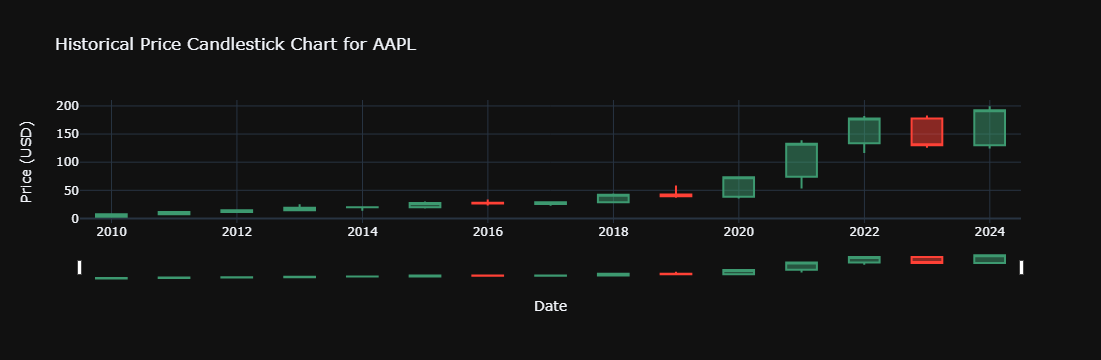

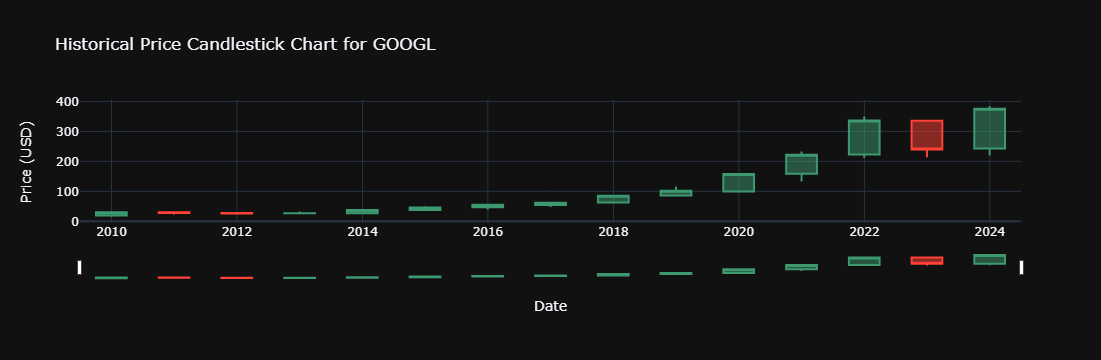

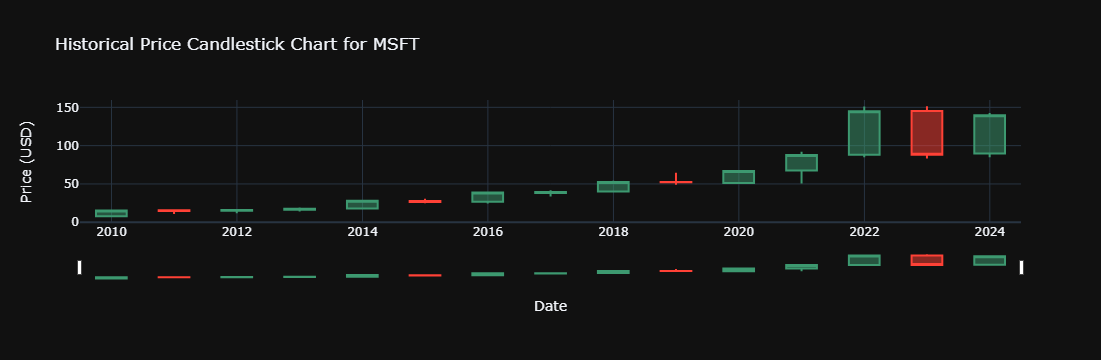

In [40]:
#Now that we have all the data, let's start visualization. We'll start with the historical price data.
# Create a candlestick chart
def visualize_historical_price(ticker,name):
    fig = go.Figure(data=[go.Candlestick(x=historical_price[ticker].index,
                                         open=historical_price[ticker]['Open'],
                                         high=historical_price[ticker]['High'],
                                         low=historical_price[ticker]['Low'],
                                         close=historical_price[ticker]['Close'])])
    
    # Update layout
    fig.update_layout(title=f'Historical Price Candlestick Chart for {ticker}',
                      xaxis_title='Date',
                      yaxis_title='Price (USD)',
                      template='plotly_dark')
    
    fig.write_html(name + '.html')
    # Show the plot
    fig.show()
visualize_historical_price('AAPL','Apple Historical Price')
visualize_historical_price('GOOGL','Google Historical Price')
visualize_historical_price('MSFT','Microsoft Historical Price')

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



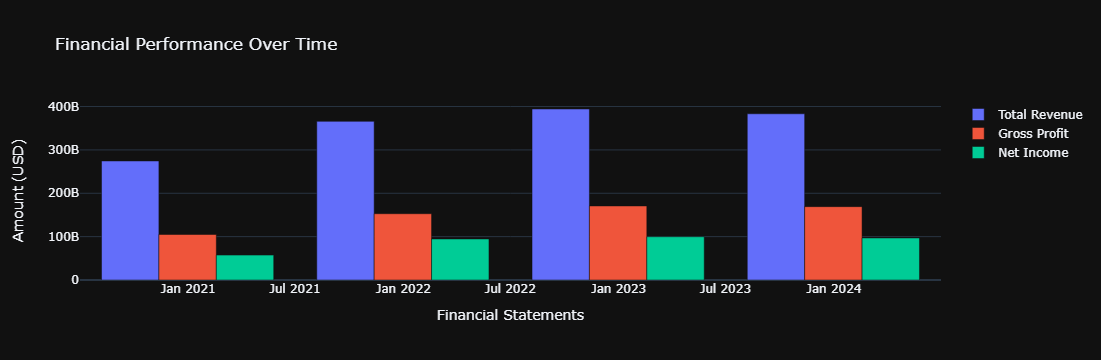

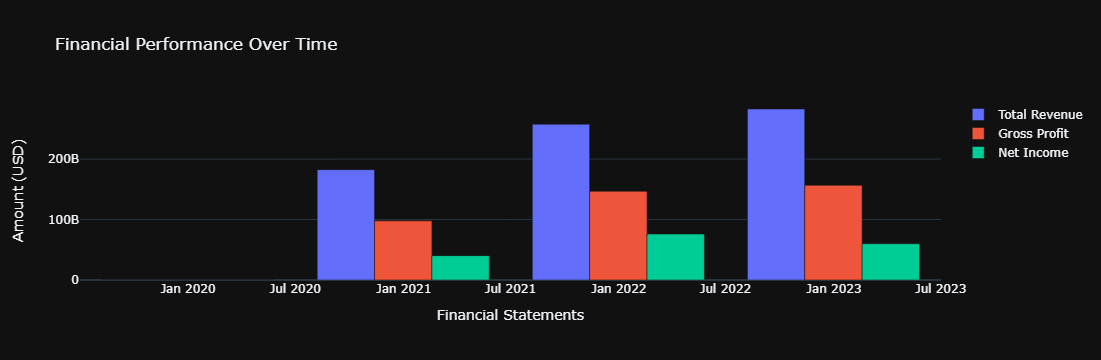

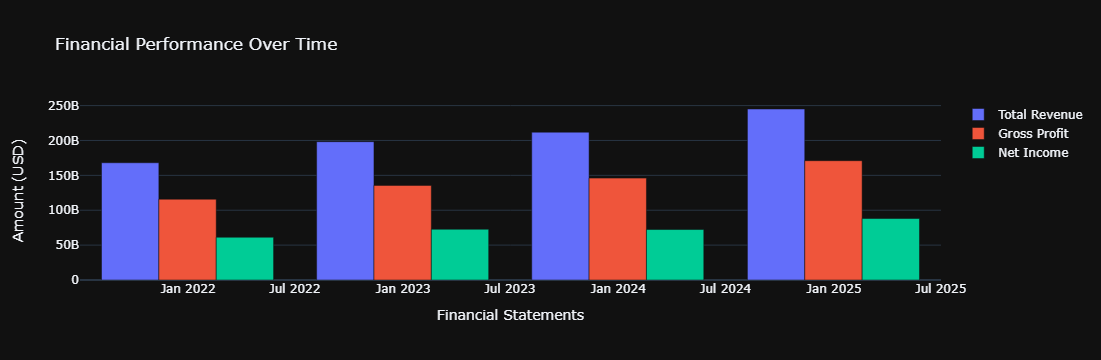

In [41]:
#Now let's try and visualize the fundamental data

#We will start with the income statements
def plot_income_statements(company,ticker,name):
    
    
    # Plotting stacked bar chart
    # Create a bar chart
    fig = go.Figure()
    
    # Add bars for each financial metric
    fig.add_trace(go.Bar(x=fundamental_data[ticker]['Date'], y=fundamental_data[ticker]["Total Revenue"], name="Total Revenue"))
    fig.add_trace(go.Bar(x=fundamental_data[ticker]['Date'], y=fundamental_data[ticker]["Gross Profit"], name="Gross Profit"))
    fig.add_trace(go.Bar(x=fundamental_data[ticker]['Date'], y=fundamental_data[ticker]["Net Income"], name="Net Income"))
    
    # Customize the layout
    fig.update_layout(
        title="Financial Performance Over Time",
        xaxis_title="Financial Statements",
        yaxis_title="Amount (USD)",
        barmode='group',
        template="plotly_dark"
    )

    fig.write_html(company + " Income Statements.html")
    fig.show()
    
plot_income_statements('Apple','AAPL','Apple Income Statements')
plot_income_statements('Google','GOOGL','Google Income Statements')
plot_income_statements('Microsoft','MSFT','Microsoft Income Statements')

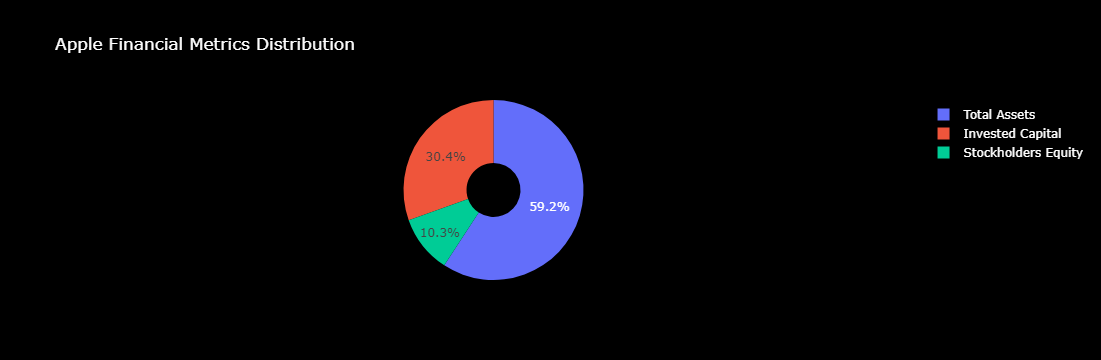

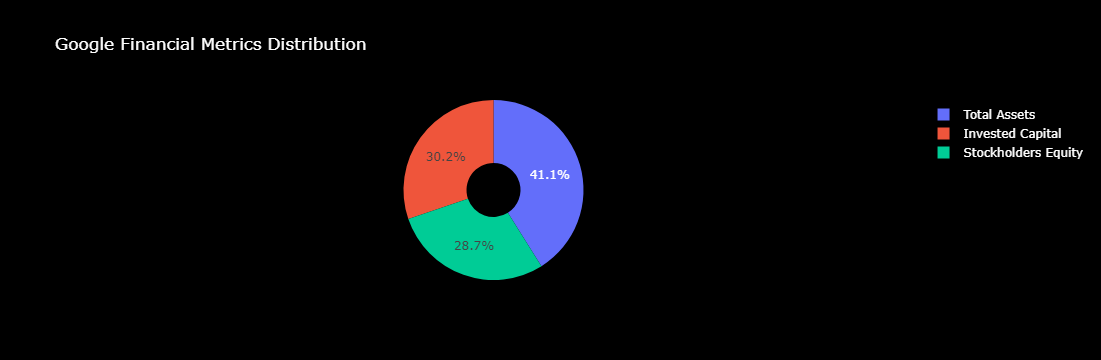

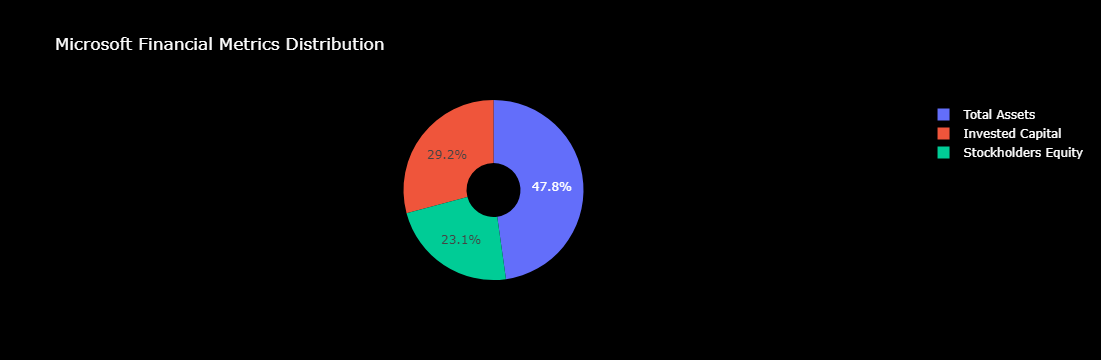

In [42]:
#Now let's plot the balance sheet data
def plot_pie_chart(company, ticker,name):
    labels = ['Total Assets','Stockholders Equity','Invested Capital']
    sizes = [fundamental_data[ticker]['Total Assets'].sum(), fundamental_data[ticker]['Stockholders Equity'].sum(),fundamental_data[ticker]['Invested Capital'].sum()]
    
    fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=.3)])
    # Customize the layout to match Ignite UI style
    fig.update_layout(
        title=company+ " Financial Metrics Distribution",
        template="plotly_white",
        showlegend=True,
        plot_bgcolor='rgba(0,0,0,1)',  
        paper_bgcolor='rgba(0, 0, 0, 1)',
        font=dict(color='white')
    )
    fig.write_html(company + " Balance Sheet Data.html")
    fig.show()
plot_pie_chart('Apple','AAPL','Apple Balance Sheet')
plot_pie_chart('Google','GOOGL','Google Balance Sheet')
plot_pie_chart('Microsoft','MSFT','Microsoft Balance Sheet')


In [43]:
#Now let's plot the cash flow data
def plot_cash_flow(company,ticker,name):
    df = pd.DataFrame({'dates': [fundamental_data[ticker]['Date']], 'freeCashFlow': [fundamental_data[ticker]['Free Cash Flow']], 
                      'investingCashFlow': [fundamental_data[ticker]['Investing Cash Flow']], 
                       'financingCashFlow': [fundamental_data[ticker]['Financing Cash Flow']]})
    jas = df.to_json(company +  ' Cash Flow Data.json',orient='records')

plot_cash_flow('Apple','AAPL','Apple Cash Flow')
plot_cash_flow('Google','GOOGL','Google Cash Flow')
plot_cash_flow('Microsoft','MSFT','Microsoft Cash Flow')

In [44]:
# Now let's view the technical indicators of each company using an interactive dashboard
import sys
def plot_technical_indicator(technical_indicator_data,company,port):

    # Initialize the Dash app
    app = dash.Dash(__name__)
    
    # Define the layout of the dashboard
    app.layout = html.Div([
        #html.H1("Technical Indicator Dashboard"),
        dcc.Graph(id='technical-indicator-graph'),
        dcc.Checklist(
            id='category-checklist',
            options=[
                {'label': 'SMA50', 'value': 'SMA50'},
                {'label': 'EMA20', 'value': 'EMA20'},
                {'label': 'RSI14', 'value': 'RSI14'},
                {'label': 'EMA12', 'value': 'EMA12'},
                {'label': 'EMA26', 'value': 'EMA26'},
                {'label': 'MACD', 'value': 'MACD'},
                {'label': 'Signal_Line', 'value': 'Signal_Line'},
                {'label': 'SMA20', 'value': 'SMA20'},
                {'label': 'STD20', 'value': 'STD20'},
                {'label': 'Upper_Band', 'value': 'Upper_Band'},
                {'label': 'Lower_Band', 'value': 'Lower_Band'}
            ],
            value=['SMA50', 'EMA20', 'RSI14'],
            inline=True,
            style={'color': '#000000'}
        )
    ])
    
    # Define the callback to update the graph based on the selected categories
    @app.callback(
        dash.dependencies.Output('technical-indicator-graph', 'figure'),
        [dash.dependencies.Input('category-checklist', 'value')]
    )
    def update_graph(selected_categories):
        # Filter data based on selected categories
        traces = []
        for category in selected_categories:
            traces.append(go.Scatter(
                x=technical_indicator_data['Date'],
                y=technical_indicator_data[category],
                mode='lines+markers',
                name=category
            ))
        
        return {
            'data': traces,
            'layout': go.Layout(
                title={
                    'text': company + ' Technical Indicators',
                    'font': {'color': '#ffffff'}  
                },
                xaxis={'title': 'Year', 'color': '#ffffff'},  
                yaxis={'title': 'Technical Indicators', 'color': '#ffffff'}, 
                hovermode='closest',
                paper_bgcolor='black',
                plot_bgcolor='black',
                font={'color': '#ffffff'}
            )
        }
    
    # Run the app
    if __name__ == '__main__':
        app.run_server(debug=True, port=port)

In [45]:
plot_technical_indicator(google_technical_indicator_data,'Apple',8050)

In [46]:
plot_technical_indicator(google_technical_indicator_data,'Google',8051)

In [47]:
plot_technical_indicator(microsoft_technical_indicator_data,'Microsoft',8052)

In [48]:
def plot_sentimental_data(company_score,company_prices,company):
    df = pd.concat([company_prices,company_score],axis=1)

    # Melt the DataFrame to have a long format suitable for box plots
    melted_data = pd.melt(df, id_vars=['compound'], 
                          value_vars=['Close', 'Open', 'High', 'Low'],
                          var_name='PriceType', value_name='Price')

    # Create the box plot
    fig = px.box(melted_data, x='PriceType', y='compound', color='PriceType',
                 title='Relationship between Sentiment Score and Stock Prices',
                 labels={'PriceType': 'Price Type', 'Price': 'Price', 'SentimentScore': 'Sentiment Score'},
                 notched=True, # To add notches to the box plot for better visual comparison
                 points="all")  # To show all data points

    # Update the layout for better appearance
    fig.update_layout(
        xaxis_title='Price Type',
        yaxis_title='Compound Score',
        boxmode='group',  # Group the boxes by PriceType
        margin=dict(l=50, r=50, t=50, b=50),
        legend_title_text='Sentiment Score',
        paper_bgcolor='black',
        plot_bgcolor='black',
        font=dict(color='white'),
        title_font=dict(color='white'),
        xaxis=dict(showgrid=True, gridcolor='gray', color='white'),
        yaxis=dict(showgrid=True, gridcolor='gray', color='white') 
    )

    # Show plot
    fig.show()

    fig.write_html(company + ' Sentimental Data.html')

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



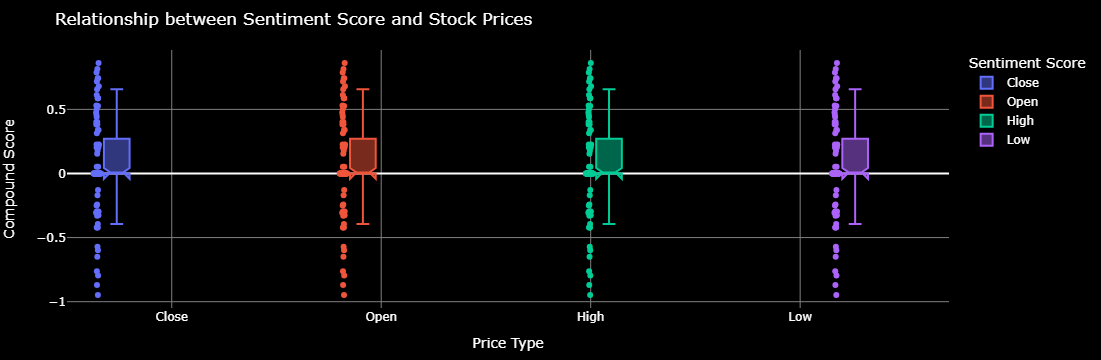

In [49]:
plot_sentimental_data(apple_score,apple_sentiment_prices,'Apple')

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



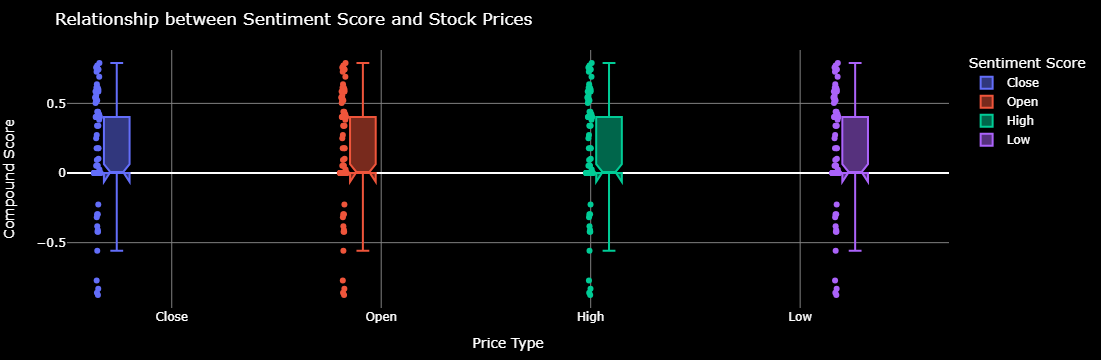

In [50]:
plot_sentimental_data(google_score,google_sentiment_prices,'Google')

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



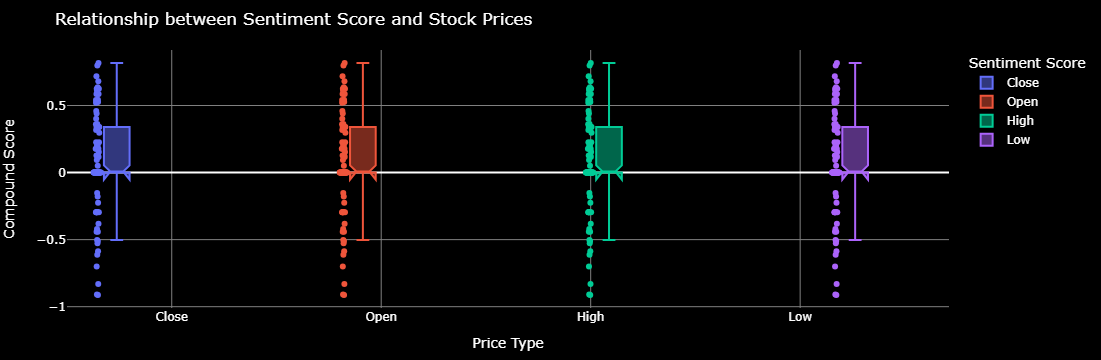

In [51]:
plot_sentimental_data(microsoft_score,microsoft_sentiment_prices,'Microsoft')

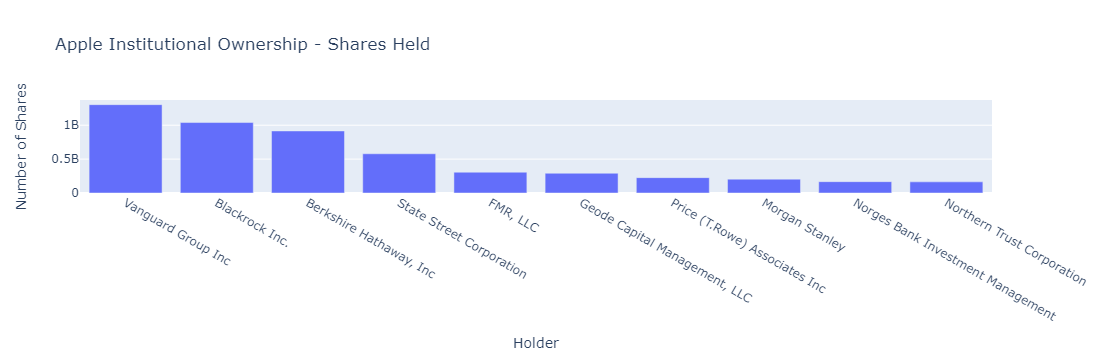

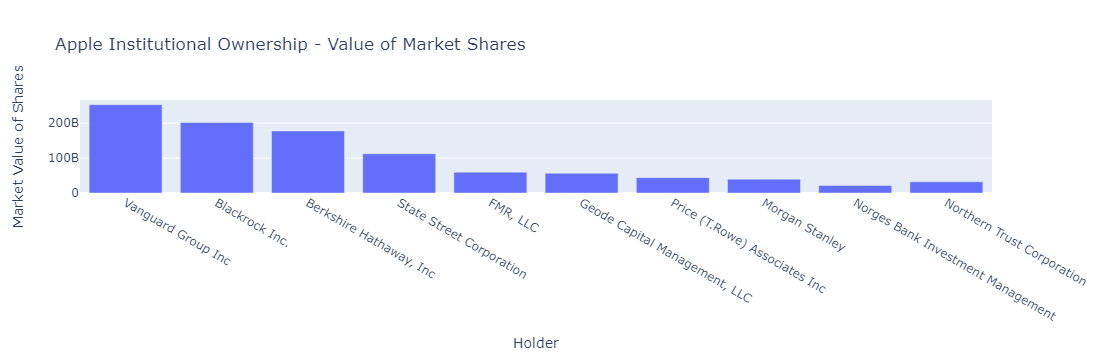

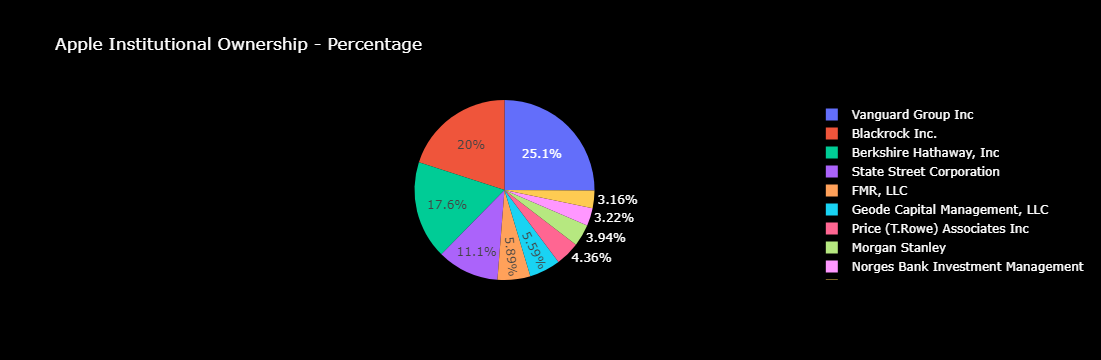

In [52]:
#Now let's try and visualize institutional ownership for the companies
def plot_insititutional_ownership(company,ticker):
    # Plot shares held by institution
    fig_shares = px.bar(institutional_ownership['AAPL'], x='Holder', y='Shares', title=company + ' Institutional Ownership - Shares Held', labels={'Shares': 'Number of Shares'})    
    fig_shares.show()
    fig_shares.update_layout(
        paper_bgcolor='black',
        plot_bgcolor='black',
        font_color='white'
    )
    # Plot the market value of the shares held by institution
    fig_value_shares = px.bar(institutional_ownership['AAPL'], x='Holder', y='Value', title=company + ' Institutional Ownership - Value of Market Shares', labels={'Value': 'Market Value of Shares'})
    fig_value_shares.show()
    fig_value_shares.update_layout(
        paper_bgcolor='black',
        plot_bgcolor='black',
        font_color='white'
    )
    # Plot percentage ownership by institution
    fig_percentage = px.pie(institutional_ownership['AAPL'], names='Holder', values='pctHeld', title=company + ' Institutional Ownership - Percentage')
    fig_percentage.update_layout(
        paper_bgcolor='black',
        plot_bgcolor='black',
        font_color='white'
    )
    fig_percentage.show()
    
    fig_combined = make_subplots(rows=1, cols=3, subplot_titles=('Shares Held', 'Value of Market Shares','Percentage'), specs=[[{"type": "bar"}, {"type": "bar"}, {"type": "pie"}]])
    for trace in fig_shares.data:
        fig_combined.add_trace(trace, row=1, col=1)
    for trace in fig_value_shares.data:
        fig_combined.add_trace(trace, row=1, col=2)
    for trace in fig_percentage.data:
        fig_combined.add_trace(trace, row=1, col=3)
    # Update layout of the combined figure
    fig_combined.update_layout(
        paper_bgcolor='black',
        plot_bgcolor='black',
        font_color='white',
        title=company + ' Institutional Ownership'
    )
    fig_combined.write_html(company + ' Institutional Ownership.html')
plot_insititutional_ownership('Apple','AAPL')

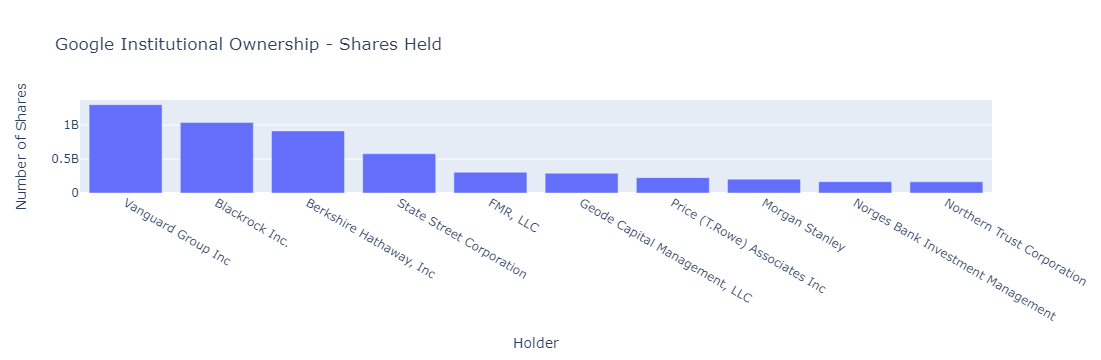

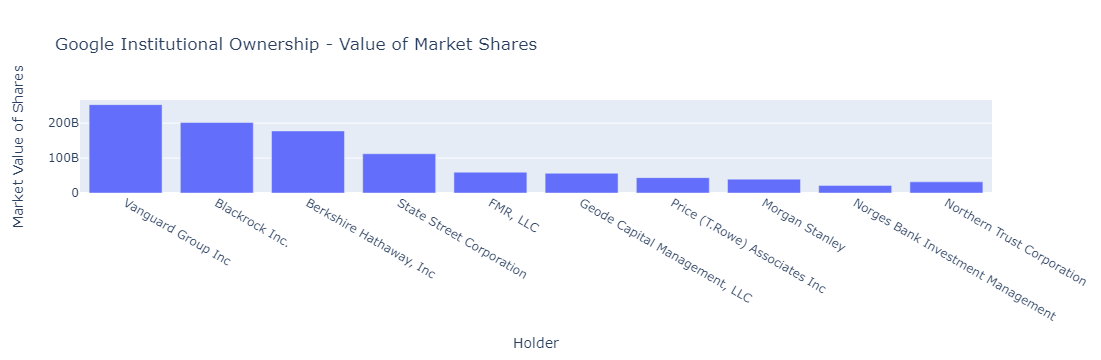

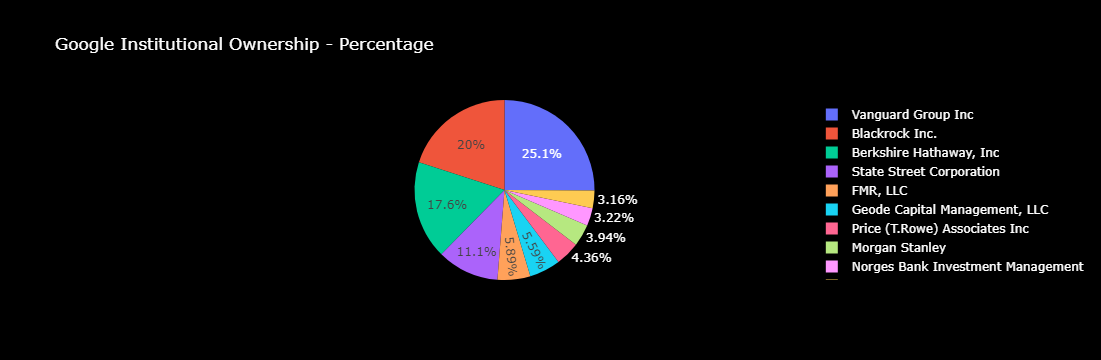

In [53]:
plot_insititutional_ownership('Google','GOOGL')

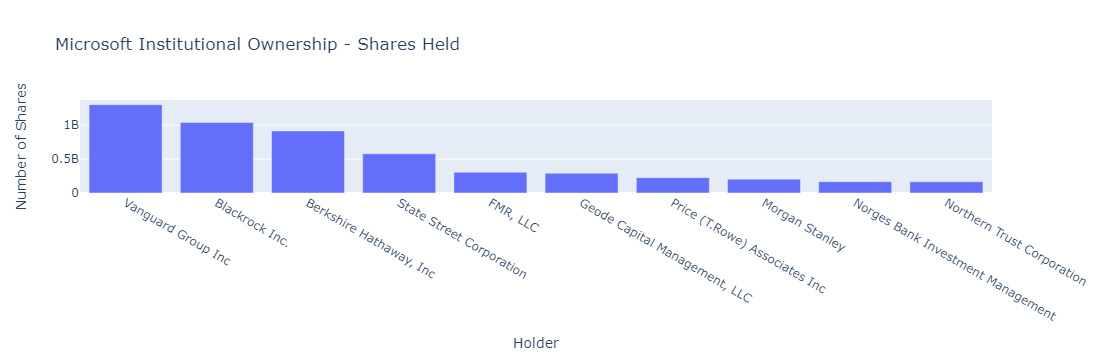

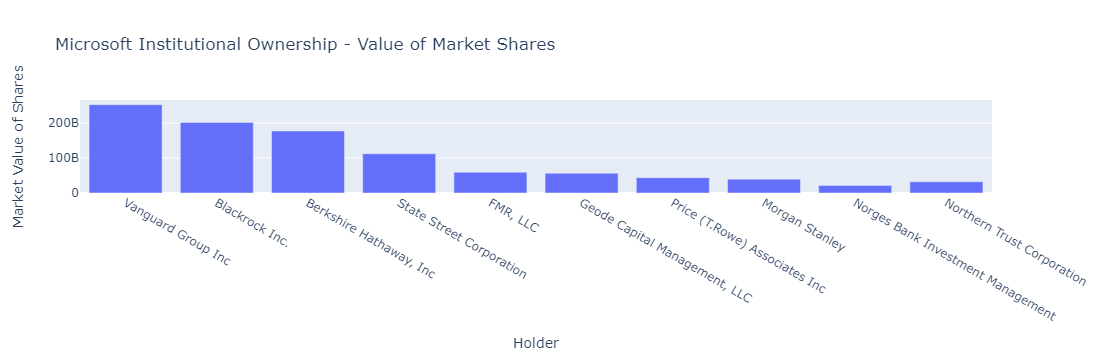

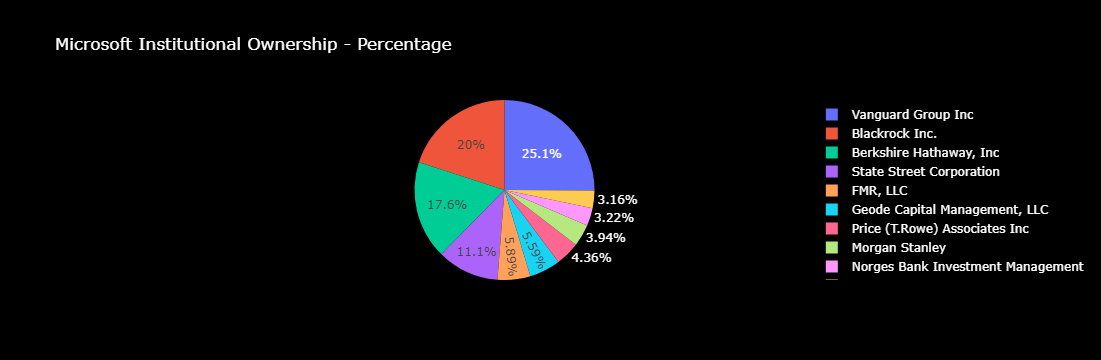

In [54]:
plot_insititutional_ownership('Microsoft','MSFT')

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



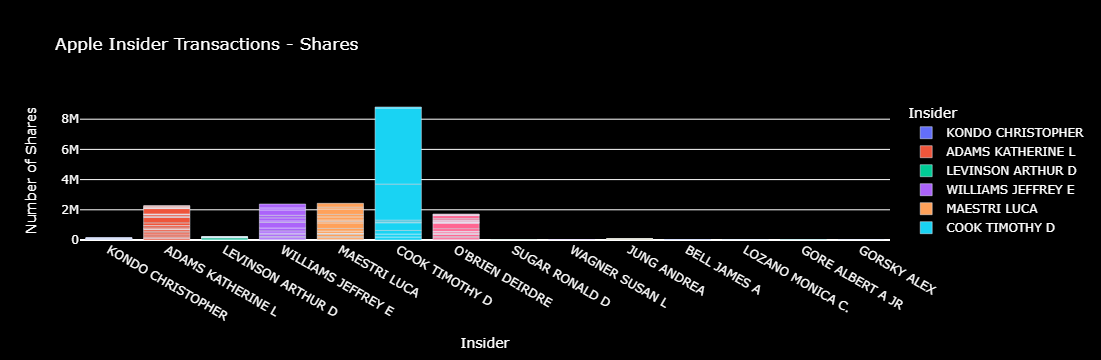

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



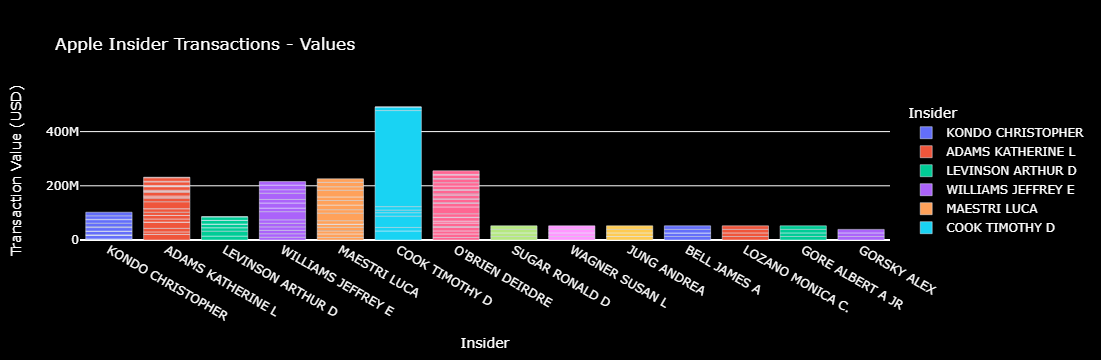

In [55]:
#Now let's plot the data for insider transactions of the companies
def plot_insider_transactions(company_transactions,company):
    # Plot shares by insider
    fig_shares = px.bar(company_transactions, x='Insider', y='Shares', color='Insider', title=company +' Insider Transactions - Shares', labels={'Shares': 'Number of Shares'})
    fig_shares.update_layout(
        plot_bgcolor='black', 
        paper_bgcolor='black',
        font_color='white',   
        title_font_color='white'
    )
    fig_shares.show()
    
    # Plot values by insider
    fig_values = px.bar(company_transactions, x='Insider', y='Value', color='Insider', title= company +' Insider Transactions - Values', labels={'Value': 'Transaction Value (USD)'})
    fig_values.update_layout(
        plot_bgcolor='black', 
        paper_bgcolor='black',
        font_color='white',   
        title_font_color='white'
    )
    fig_values.show()

    fig_combined = make_subplots(rows=1, cols=2, subplot_titles=('Shares Held', 'Value of Market Shares'), specs=[[{"type": "bar"}, {"type": "bar"}]])
    for trace in fig_shares.data:
        fig_combined.add_trace(trace, row=1, col=1)
    for trace in fig_values.data:
        fig_combined.add_trace(trace, row=1, col=2)
    fig_combined.update_layout(
        plot_bgcolor='black', 
        paper_bgcolor='black',
        font_color='white',   
        title_font_color='white'
    )
    fig_combined.write_html(company + ' Insider Transactions.html')
plot_insider_transactions(apple_insider_transactions,'Apple')

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



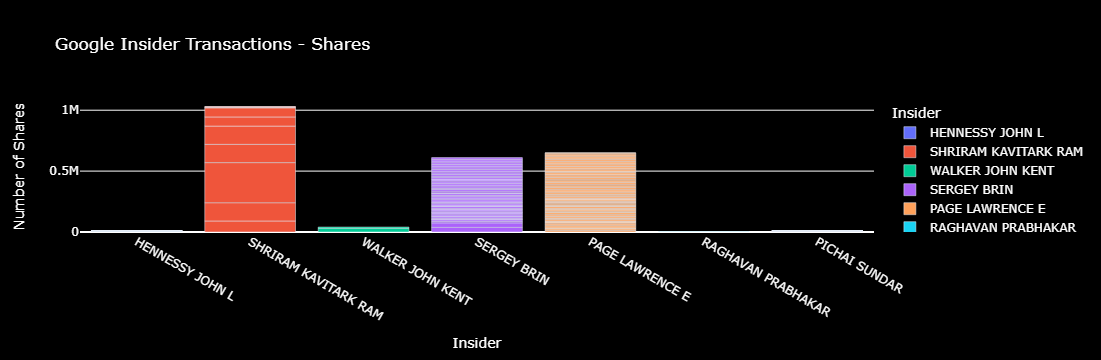

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



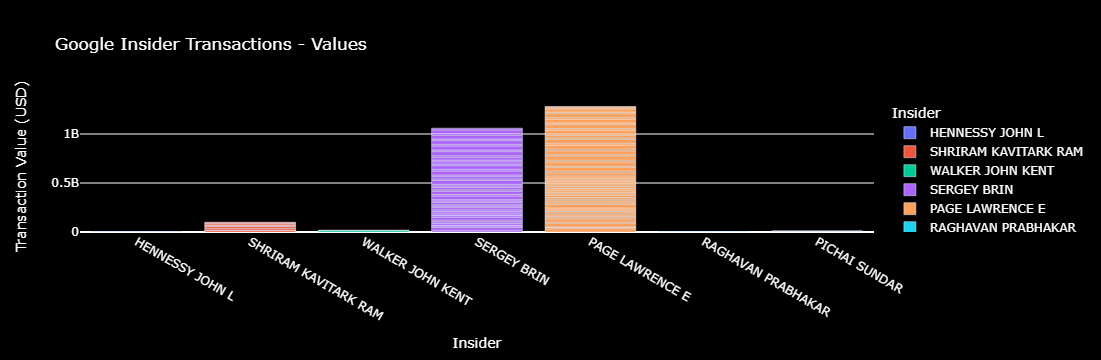

In [56]:
plot_insider_transactions(google_insider_transactions,'Google')

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



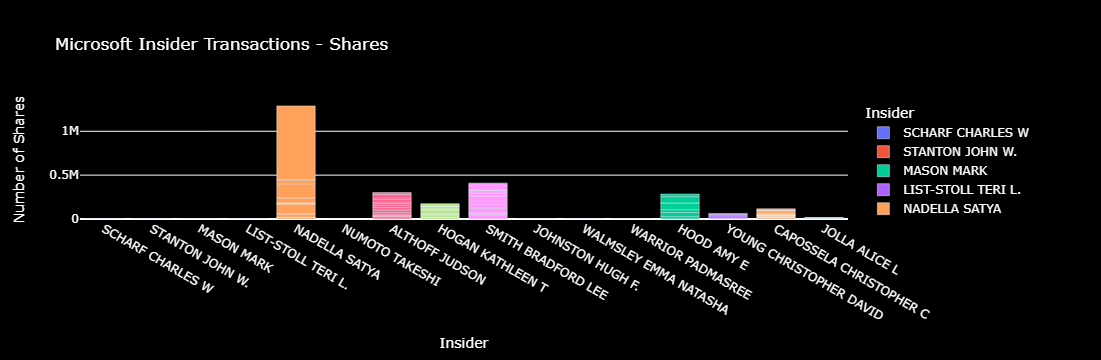

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



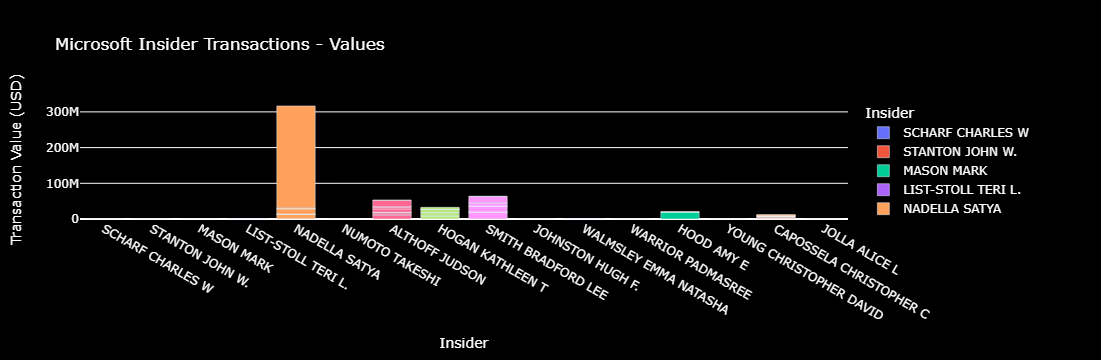

In [57]:
plot_insider_transactions(microsoft_insider_transactions,'Microsoft')

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



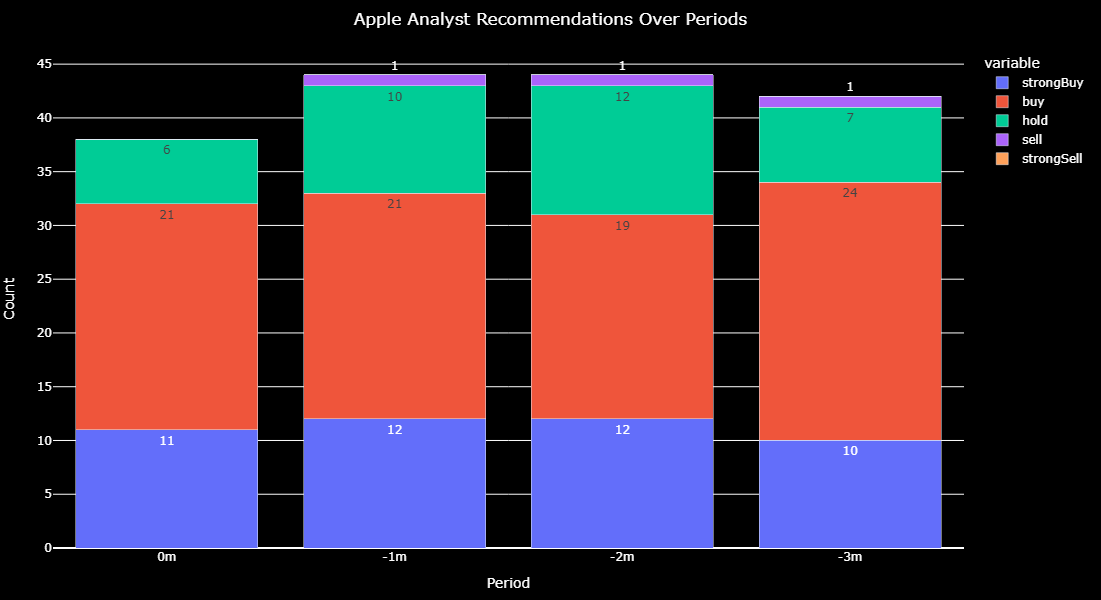

In [58]:
#Finally, let's plot the analyst ratings of each company to know what expert analysts believe we should put our stocks in over different time periods
def plot_analyst_ratings(company,ratings):
    fig = px.bar(ratings, x='period', y=['strongBuy', 'buy', 'hold', 'sell', 'strongSell'],
                 title= company + ' Analyst Recommendations Over Periods',
                 labels={'value': 'Count', 'period': 'Period'},
                 color_discrete_sequence=px.colors.qualitative.Plotly,
                 text_auto=True)
    # Update layout to increase size and adjust margins
    fig.update_layout(
        height=600,  # Increase height
        width=1000,  # Increase width
        barmode='stack',  # Ensure bars are stacked
        title_x=0.5,  # Center title
        xaxis_title='Period',
        yaxis_title='Count',
        margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins to ensure no clipping
        plot_bgcolor='#000000',
        paper_bgcolor='#000000',
        font_color='#FFFFFF'
    )
    # Show the plot
    fig.write_html(company + ' Analyst Recommendations.html')
    fig.show()
plot_analyst_ratings('Apple', apple_analyst_ratings)

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



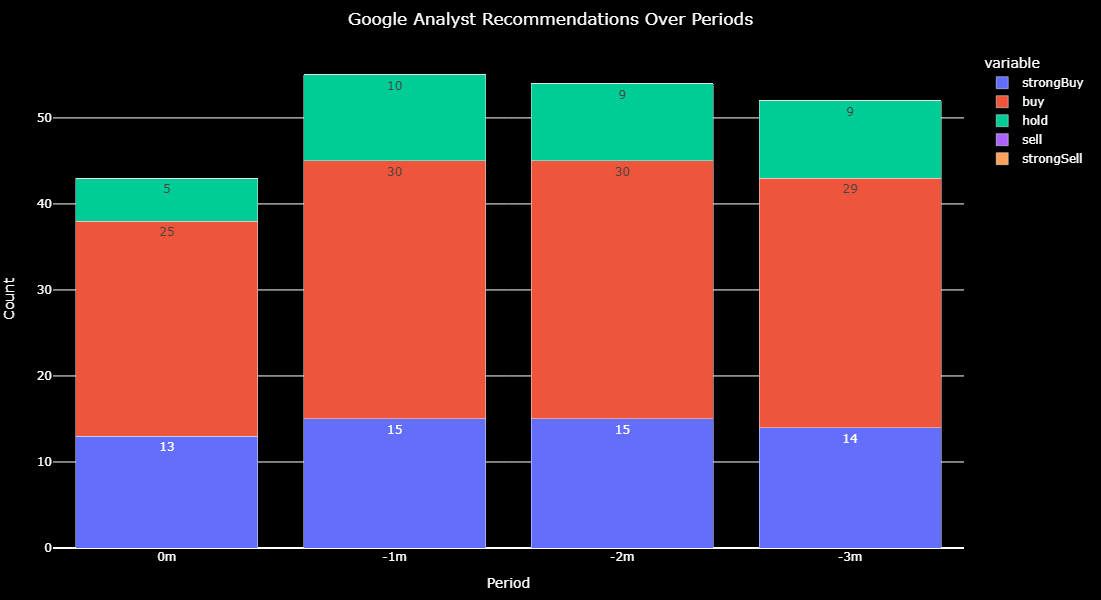

In [59]:
plot_analyst_ratings('Google', google_analyst_ratings)

C:\Users\Olurotimi Ajayi\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



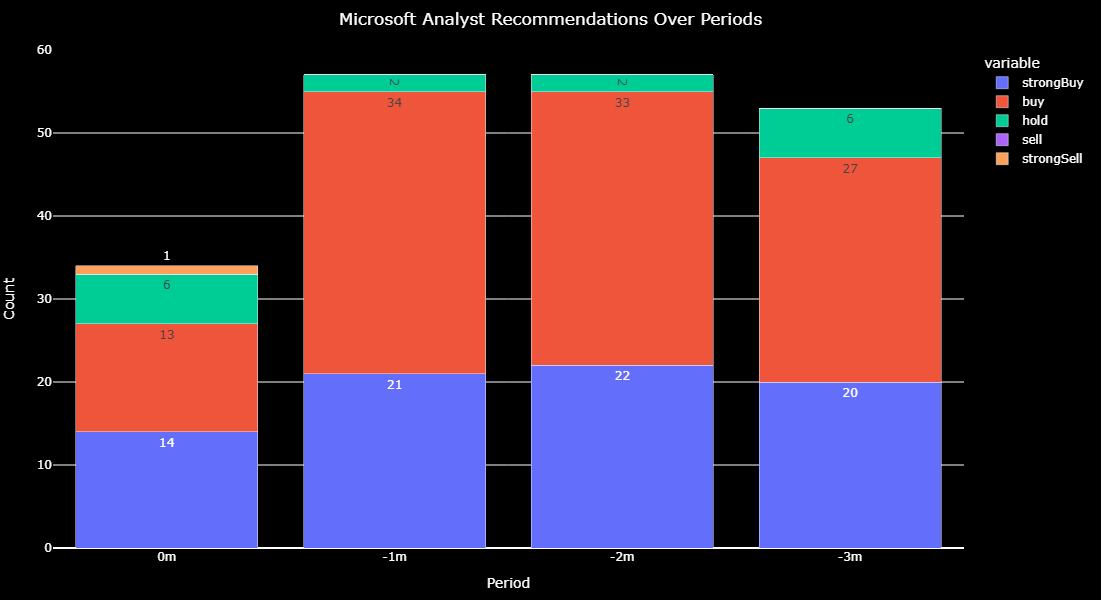

In [60]:
plot_analyst_ratings('Microsoft', microsoft_analyst_ratings)

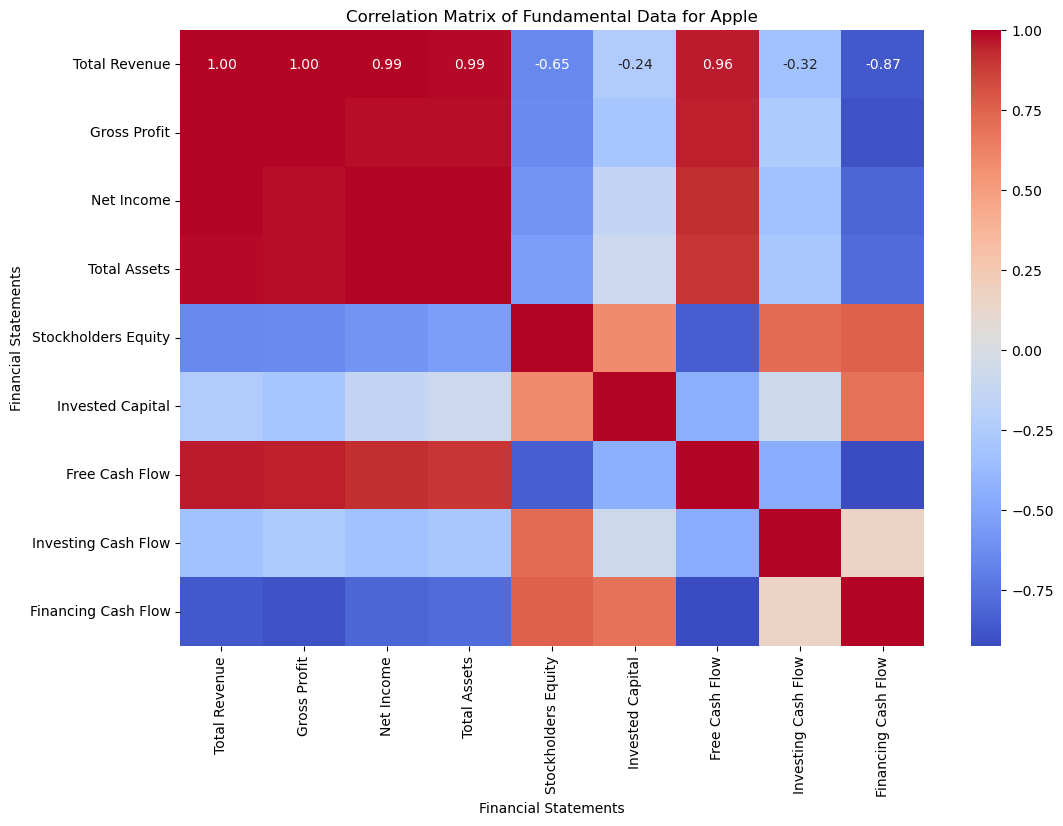

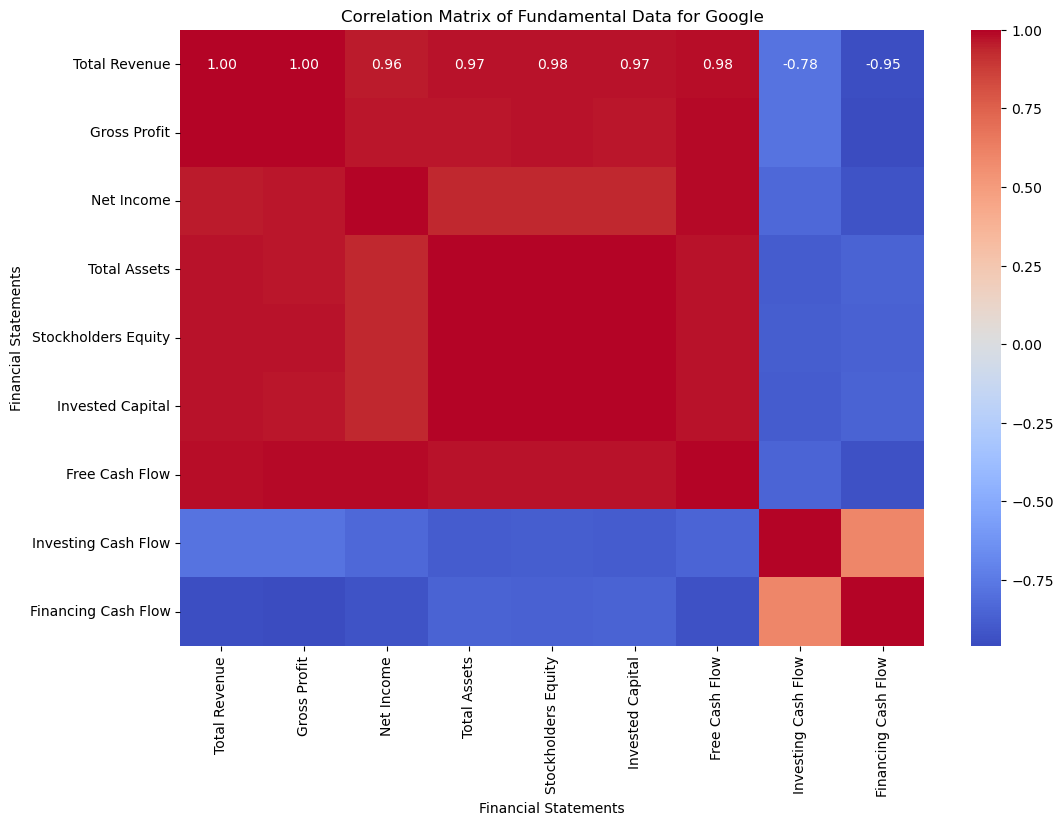

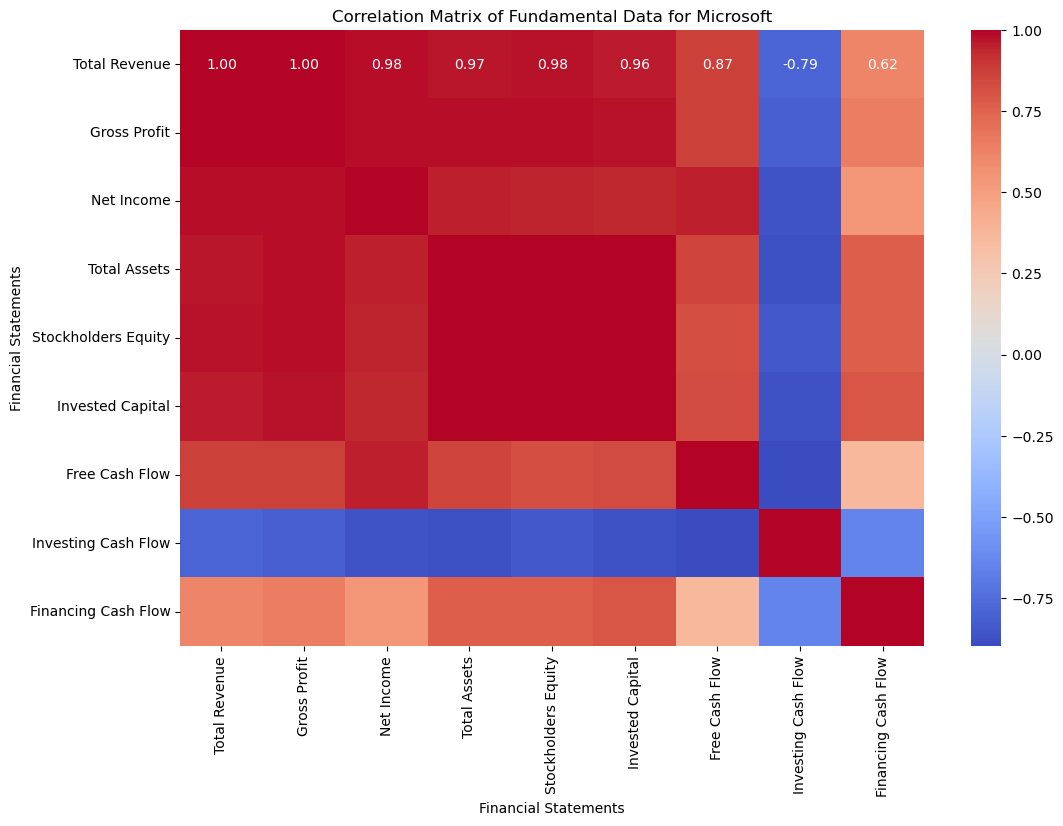

In [61]:
#Now that we have these plots, let's check for a correlation in any of the dataframes to drop unnecessary columns and reduce redundancy
#For fundamental data
ran = fundamental_data['AAPL'].drop('Date',axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(ran, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fundamental Data for Apple')
plt.savefig('Apple Fundamental Data Correlation Matrix.png')
plt.show()

ran = fundamental_data['GOOGL'].drop('Date',axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(ran, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fundamental Data for Google')
plt.savefig('Google Fundamental Data Correlation Matrix.png')
plt.show()

ran = fundamental_data['MSFT'].drop('Date',axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(ran, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fundamental Data for Microsoft')
plt.savefig('Microsoft Fundamental Data Correlation Matrix.png')
plt.show()

In [62]:
#Drop Gross Profit, Net Income and Total Assets
fundamental_data = fundamental_data.drop(['Gross Profit','Net Income','Total Assets'],level=1,axis=1)

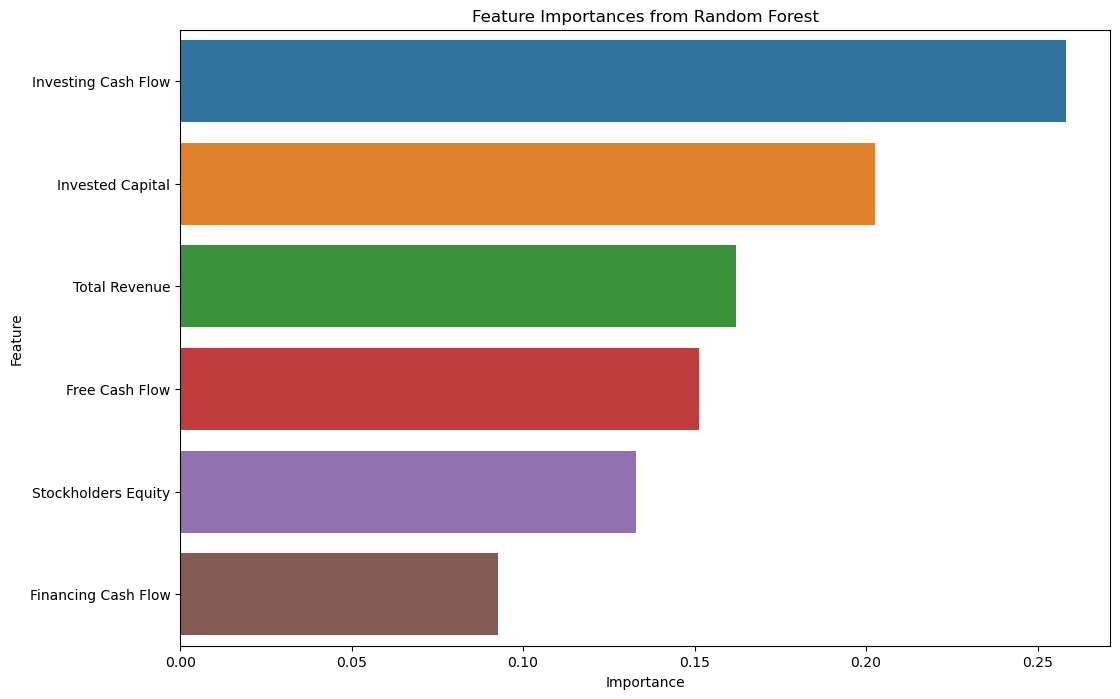

In [63]:
# Assuming 'historical_price' contains your target variable 'Close'
X = fundamental_data['AAPL'].drop('Date',axis=1)
y =historical_price['AAPL']['Close'].iloc[-4:]

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.savefig('Apple Historical Price Feature Importances from Random Forest.png')
plt.show()


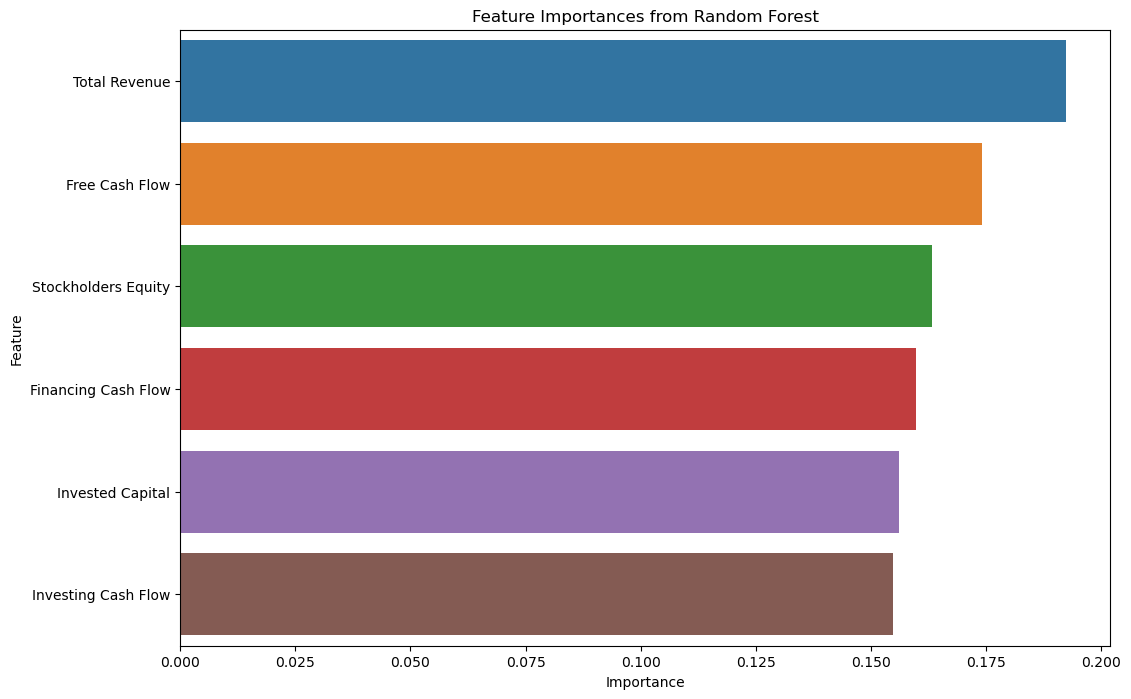

In [64]:
# Assuming 'historical_price' contains your target variable 'Close
X = fundamental_data['GOOGL'].drop('Date',axis=1)
y =historical_price['GOOGL']['Close'].iloc[-4:]

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.savefig('Google Historical Price Feature Importances from Random Forest.png')
plt.show()


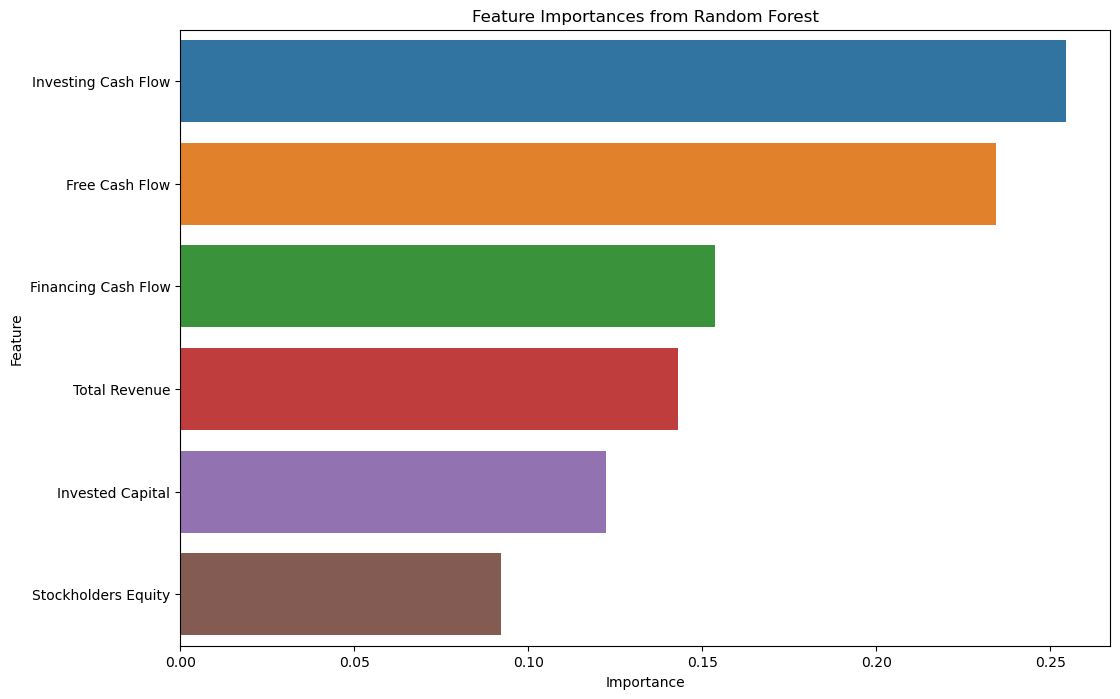

In [65]:
# Assuming 'historical_price' contains your target variable 'Close'
X = fundamental_data['MSFT'].drop('Date',axis=1)
y =historical_price['MSFT']['Close'].iloc[-4:]

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.savefig('Microsoft Historical Price Feature Importances from Random Forest.png')
plt.show()


In [66]:
#Drop Stockholders Equity and Financing Cash Flow
fundamental_data = fundamental_data.drop(['Stockholders Equity','Financing Cash Flow'],axis=1,level=1)

In [67]:
fundamental_data

Ticker                     AAPL                                                \
Financial Statements       Date Total Revenue Invested Capital Free Cash Flow   
0                    2020-12-31  2.745150e+11     1.777750e+11   7.336500e+10   
1                    2021-12-31  3.658170e+11     1.878090e+11   9.295300e+10   
2                    2022-12-31  3.943280e+11     1.707410e+11   1.114430e+11   
3                    2023-12-31  3.832850e+11     1.732340e+11   9.958400e+10   

Ticker                                        GOOGL                \
Financial Statements Investing Cash Flow       Date Total Revenue   
0                          -4.289000e+09 2019-12-31  0.000000e+00   
1                          -1.454500e+10 2020-12-31  1.825270e+11   
2                          -2.235400e+10 2021-12-31  2.576370e+11   
3                           3.705000e+09 2022-12-31  2.828360e+11   

Ticker                                                                    \
Financial Statements Invested Capital Free Cash Flow Investing Cash Flow   
0                        0.000000e+00   0.000000e+00        0.000000e+00   
1                        2.353760e+11   4.284300e+10       -3.277300e+10   
2                        2.644790e+11   6.701200e+10       -3.552300e+10   
3                        2.690010e+11   6.001000e+10       -2.029800e+10   

Ticker                     MSFT                                                \
Financial Statements       Date Total Revenue Invested Capital Free Cash Flow   
0                    2021-12-31  1.680880e+11     2.001340e+11   5.611800e+10   
1                    2022-12-31  1.982700e+11     2.163230e+11   6.514900e+10   
2                    2023-12-31  2.119150e+11     2.534600e+11   5.947500e+10   
3                    2024-12-31  2.451220e+11     3.201070e+11   7.407100e+10   

Ticker                                    
Financial Statements Investing Cash Flow  
0                          -2.757700e+10  
1                          -3.031100e+10  
2                          -2.268000e+10  
3                          -9.697000e+10

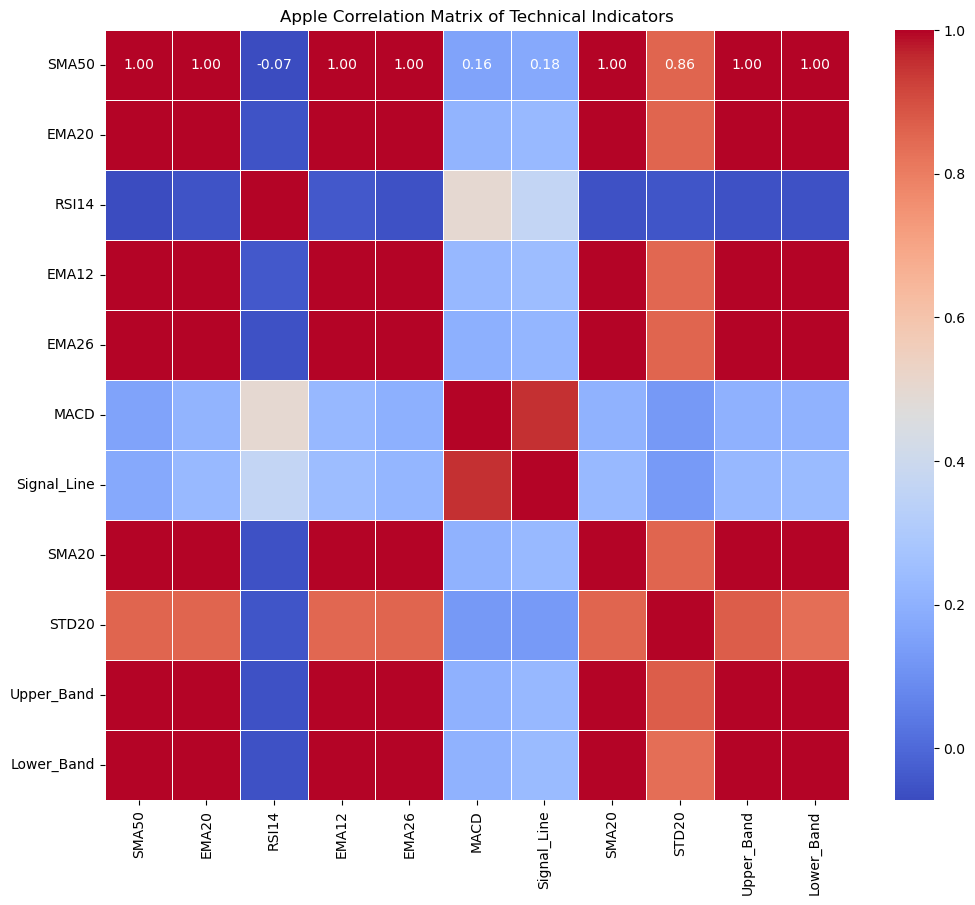

In [68]:
#Now let's see the correlation between technical indicators columns and the close price
def plot_technical_indicators_correlation(df,company):
    # Compute correlation matrix
    correlation_matrix = df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(company + ' Correlation Matrix of Technical Indicators')
    plt.savefig(company + ' Correlation Matrix of Technical Indicators.png')
    plt.show()
plot_technical_indicators_correlation(apple_technical_indicator_data.drop(columns='Date'),'Apple')

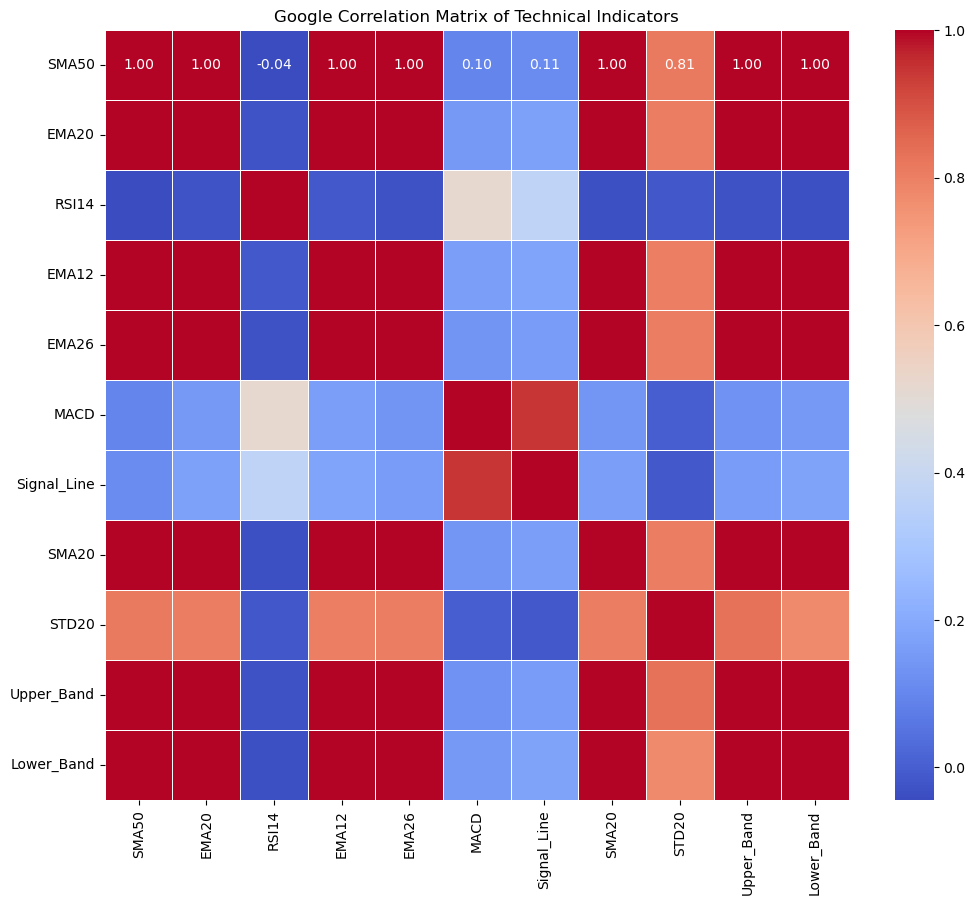

In [69]:
plot_technical_indicators_correlation(google_technical_indicator_data.drop(columns='Date'),'Google')

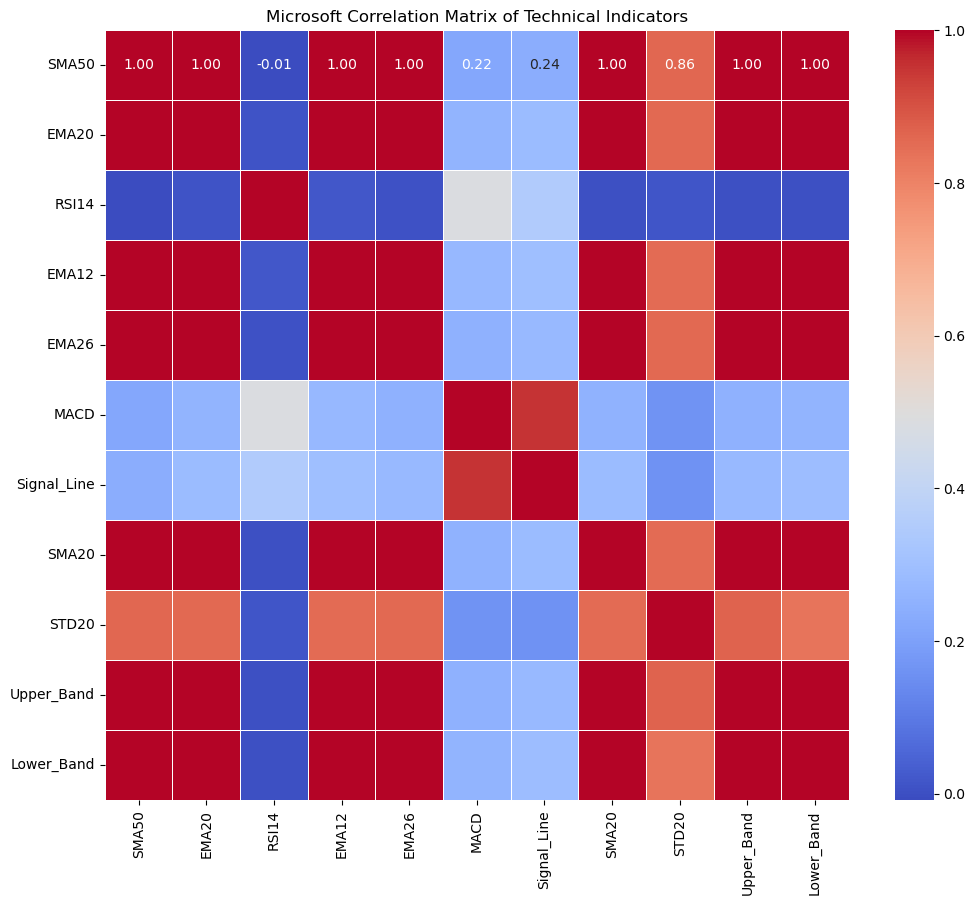

In [70]:
plot_technical_indicators_correlation(microsoft_technical_indicator_data.drop(columns='Date'),'Microsoft')

In [71]:
#Drop EMA20,SMA20,EM12,EM26, Upper_Band  and Lower_Band
apple_technical_indicator_data = apple_technical_indicator_data.drop(columns=['EMA20','SMA20','EMA12','EMA26','Upper_Band','Lower_Band'])
google_technical_indicator_data = google_technical_indicator_data.drop(columns=['EMA20','SMA20','EMA12','EMA26','Upper_Band','Lower_Band'])
microsoft_technical_indicator_data = microsoft_technical_indicator_data.drop(columns=['EMA20','SMA20','EMA12','EMA26','Upper_Band','Lower_Band'])

In [72]:
#Format the technical indicator data to display yearly data
def resample_technical_indicator_data(df):
    df.set_index('Date',inplace=True)
    df_yearly = df.resample('YE').sum()
    df_yearly.reset_index(inplace=True)
    return df_yearly
apple_technical_indicator_data = resample_technical_indicator_data(apple_technical_indicator_data)
google_technical_indicator_data = resample_technical_indicator_data(google_technical_indicator_data)
microsoft_technical_indicator_data = resample_technical_indicator_data(microsoft_technical_indicator_data)

In [73]:
apple_technical_indicator_data

Date         SMA50         RSI14        MACD  Signal_Line  \
0  2009-12-31   1066.800478  12842.652935   26.868893    26.530937   
1  2010-12-31   2235.052097  15191.607282   29.747510    29.506562   
2  2011-12-31   3213.432425  13583.369354   17.974150    18.077501   
3  2012-12-31   5008.734247  14364.063486   39.874908    42.393295   
4  2013-12-31   4249.754880  13196.706941   -0.484466    -3.726294   
5  2014-12-31   5602.252235  14703.565260   59.321334    60.240344   
6  2015-12-31   7559.764739  12444.854793    2.094729     4.512676   
7  2016-12-31   6588.758997  13526.211767    0.393715    -3.138265   
8  2017-12-31   9088.661635  15449.638158  101.147220   101.444601   
9  2018-12-31  11853.643629  13165.380638    7.072205    17.455588   
10 2019-12-31  12512.142606  15809.937151  165.674626   149.312977   
11 2020-12-31  22741.441530  15296.255477  395.481850   388.874357   
12 2021-12-31  34454.087005  13973.681630  306.390462   299.886375   
13 2022-12-31  39556.001822  11923.263274 -188.323109  -153.758666   
14 2023-12-31  41882.714445  14536.328097  351.911863   327.739066   

          STD20  
0     39.033661  
1     68.468455  
2     88.737783  
3    170.011133  
4    132.456919  
5    137.108031  
6    185.746065  
7    179.343234  
8    188.771589  
9    353.140349  
10   367.854113  
11  1008.946809  
12   937.573393  
13  1414.170999  
14  1055.472567

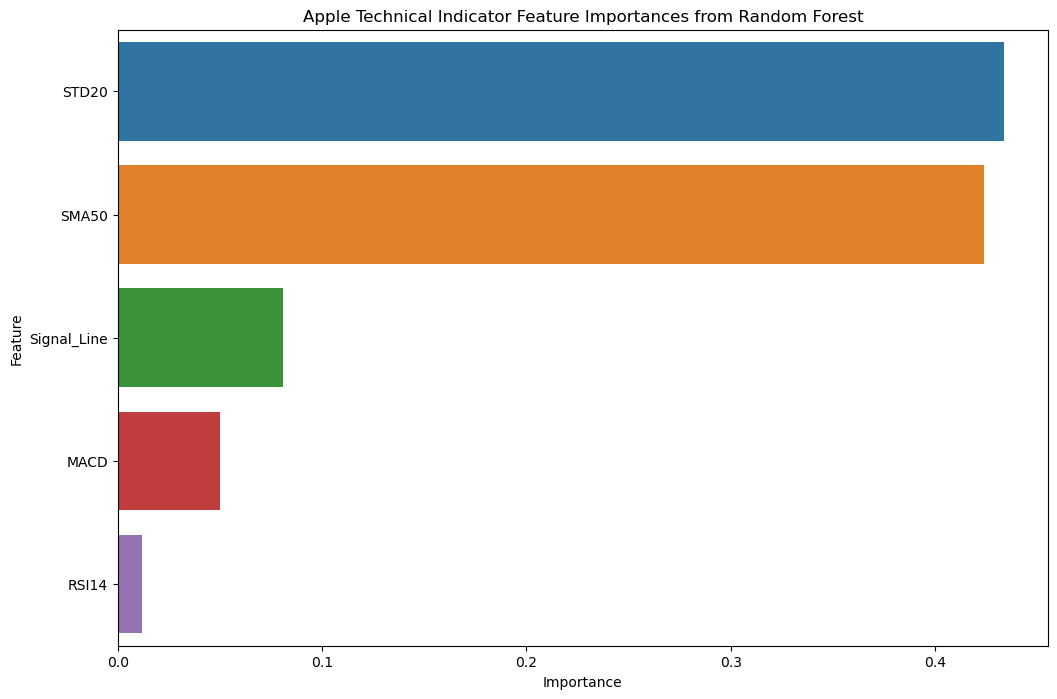

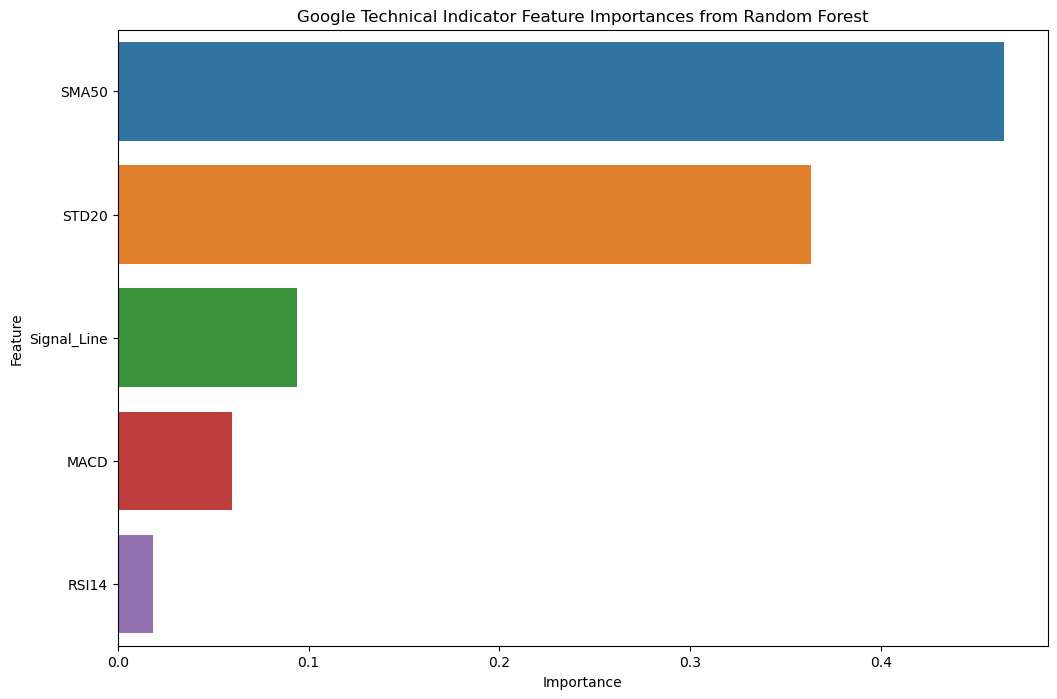

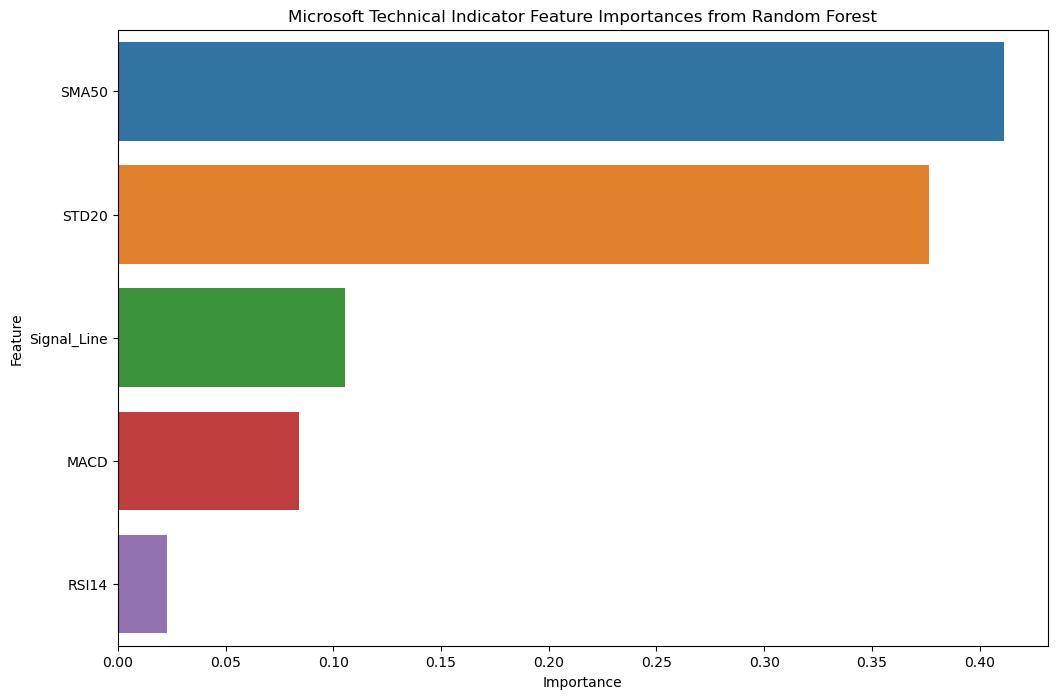

In [74]:
#Check the feature importance for the technical indicator and Close price
def feature_indicator_close(indicator,ticker,company):
    X =indicator.drop(columns='Date')
    y =historical_price[ticker]['Close']
    
    # Train a Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # Get feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(company + ' Technical Indicator Feature Importances from Random Forest')
    plt.show()
feature_indicator_close(apple_technical_indicator_data,'AAPL','Apple')
feature_indicator_close(google_technical_indicator_data,'GOOGL','Google')
feature_indicator_close(microsoft_technical_indicator_data,'MSFT','Microsoft')

In [75]:
#Drop the Signal_Line, MACD and RSI14 columns
apple_technical_indicator_data.drop(columns=['RSI14','MACD','Signal_Line'],inplace=True)
google_technical_indicator_data.drop(columns=['RSI14','MACD','Signal_Line'],inplace=True)
microsoft_technical_indicator_data.drop(columns=['RSI14','MACD','Signal_Line'],inplace=True)

In [76]:
apple_technical_indicator_data

Date         SMA50        STD20
0  2009-12-31   1066.800478    39.033661
1  2010-12-31   2235.052097    68.468455
2  2011-12-31   3213.432425    88.737783
3  2012-12-31   5008.734247   170.011133
4  2013-12-31   4249.754880   132.456919
5  2014-12-31   5602.252235   137.108031
6  2015-12-31   7559.764739   185.746065
7  2016-12-31   6588.758997   179.343234
8  2017-12-31   9088.661635   188.771589
9  2018-12-31  11853.643629   353.140349
10 2019-12-31  12512.142606   367.854113
11 2020-12-31  22741.441530  1008.946809
12 2021-12-31  34454.087005   937.573393
13 2022-12-31  39556.001822  1414.170999
14 2023-12-31  41882.714445  1055.472567

In [77]:
#Now let's look at insider transactions
#Resample insider transactions data to display yearly data
def resample_insider_transactions_data(df):
    df.set_index('Date',inplace=True)
    df.drop(columns='Insider',inplace=True)
    df_yearly = df.resample('YE').sum()
    df_yearly.reset_index(inplace=True)
    return df_yearly

In [78]:
apple_insider_transactions = resample_insider_transactions_data(apple_insider_transactions)

In [79]:
google_insider_transactions	 = resample_insider_transactions_data(google_insider_transactions)

In [80]:
microsoft_insider_transactions = resample_insider_transactions_data(microsoft_insider_transactions)

In [81]:
fundamental_data['AAPL']

Financial Statements       Date  Total Revenue  Invested Capital  \
0                    2020-12-31   2.745150e+11      1.777750e+11   
1                    2021-12-31   3.658170e+11      1.878090e+11   
2                    2022-12-31   3.943280e+11      1.707410e+11   
3                    2023-12-31   3.832850e+11      1.732340e+11   

Financial Statements  Free Cash Flow  Investing Cash Flow  
0                       7.336500e+10        -4.289000e+09  
1                       9.295300e+10        -1.454500e+10  
2                       1.114430e+11        -2.235400e+10  
3                       9.958400e+10         3.705000e+09

In [82]:
#Now that we have our relevant data for model prediction, let'd create a large dataframe that we can use
def create_final_dataframe(df,ticker,technical_indicator,insider_transactions):
    df = historical_price[ticker].reset_index()
    df = df.merge(fundamental_data[ticker],on='Date',how='outer')
    df = df.merge(technical_indicator,on='Date',how='outer')
    df = df.merge(insider_transactions,on='Date',how='outer')
    df = df.drop(df.index[-1])
    return df

In [83]:
apple_final_df = create_final_dataframe(fundamental_data,'AAPL',apple_technical_indicator_data,apple_insider_transactions)
google_final_df = create_final_dataframe(fundamental_data,'GOOGL',google_technical_indicator_data,google_insider_transactions)
microsoft_final_df = create_final_dataframe(fundamental_data,'MSFT',microsoft_technical_indicator_data,microsoft_insider_transactions)

In [84]:
#There are a lot of missing values and too many to just drop. Let's try and fill in these values using linear regression for each column
def fill_apple_na_with_linear_reg(df,column):
    X_train = df[['Close','SMA50','STD20']][11:]
    y_train = df[column][11:]
    X_predict = df[['Close','SMA50','STD20']][:11]
    # Train a simple Linear Regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_predict)
    # for i in range(len(predicted_values)):
    #     df.iloc[i][column] = predicted_values[i]
    nan_indices = df[df[column].isna()].index
    predicted_series = pd.Series(predicted_values,index=nan_indices)
    df[column] = df[column].fillna(predicted_series)
    return df

In [85]:
def fill_google_na_with_linear_reg(df,column):
    if column == 'Shares' or column == 'Value':
        X_train = df.drop(columns=['Shares','Value','Date'])[12:]
        y_train = df[column][12:]
        X_predict = df.drop(columns=['Shares','Value','Date'])[:12]
    else:
        X_train = df[['Open','High','Low','Close','Volume','SMA50','STD20']][10:14]
        y_train = df[column][10:14]
        X_predict = pd.concat([df[['Open','High','Low','Close','Volume','SMA50','STD20']][:10],df[['Open','High','Low','Close','Volume','SMA50','STD20']][14:]])
    # Train a simple Linear Regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_predict)
    # for i in range(len(predicted_values)):
    #     df.iloc[i][column] = predicted_values[i]
    nan_indices = df[df[column].isna()].index
    predicted_series = pd.Series(predicted_values,index=nan_indices)
    df[column] = df[column].fillna(predicted_series)
    return df

In [86]:
def fill_microsoft_na_with_linear_reg(df,column):
    X_train = df[['Open','High','Low','Close','Volume','SMA50','STD20']][12:]
    y_train = df[column][12:]
    X_predict = df[['Open','High','Low','Close','Volume','SMA50','STD20']][:12]
    # Train a simple Linear Regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_predict)
    # for i in range(len(predicted_values)):
    #     df.iloc[i][column] = predicted_values[i]
    nan_indices = df[df[column].isna()].index
    predicted_series = pd.Series(predicted_values,index=nan_indices)
    df[column] = df[column].fillna(predicted_series)
    return df

In [87]:
apple_final_df = fill_apple_na_with_linear_reg(apple_final_df,'Total Revenue')
apple_final_df = fill_apple_na_with_linear_reg(apple_final_df,'Invested Capital')
apple_final_df = fill_apple_na_with_linear_reg(apple_final_df,'Free Cash Flow')
apple_final_df = fill_apple_na_with_linear_reg(apple_final_df,'Investing Cash Flow')
apple_final_df = fill_apple_na_with_linear_reg(apple_final_df,'Shares')
apple_final_df = fill_apple_na_with_linear_reg(apple_final_df,'Value')

google_final_df = fill_google_na_with_linear_reg(google_final_df,'Total Revenue')
google_final_df = fill_google_na_with_linear_reg(google_final_df,'Invested Capital')
google_final_df = fill_google_na_with_linear_reg(google_final_df,'Free Cash Flow')
google_final_df = fill_google_na_with_linear_reg(google_final_df,'Investing Cash Flow')
google_final_df = fill_google_na_with_linear_reg(google_final_df,'Shares')
google_final_df = fill_google_na_with_linear_reg(google_final_df,'Value')

microsoft_final_df = fill_microsoft_na_with_linear_reg(microsoft_final_df,'Total Revenue')
microsoft_final_df = fill_microsoft_na_with_linear_reg(microsoft_final_df,'Invested Capital')
microsoft_final_df = fill_microsoft_na_with_linear_reg(microsoft_final_df,'Free Cash Flow')
microsoft_final_df = fill_microsoft_na_with_linear_reg(microsoft_final_df,'Investing Cash Flow')
microsoft_final_df = fill_microsoft_na_with_linear_reg(microsoft_final_df,'Shares')
microsoft_final_df = fill_microsoft_na_with_linear_reg(microsoft_final_df,'Value')

In [88]:
#Now let's try and get the data for 2024 for each company
def fetch_2024_data(ticker):
    df = yf.download(ticker, start='2024-01-01', end='2024-04-01')
    open_price = df.iloc[-1]['Open']
    high_price = df.iloc[-1]['High']
    low_price = df.iloc[-1]['Low']
    close_price = df.iloc[-1]['Close']
    volume = df.iloc[-1]['Volume']
    total_revenue = yf.Ticker(ticker).quarterly_financials.loc['Total Revenue']['2024-03-31']
    invested_capital = yf.Ticker(ticker).quarterly_balance_sheet.loc['Invested Capital']['2024-03-31']
    free_cash_flow = yf.Ticker(ticker).quarterly_cashflow.loc['Free Cash Flow']['2024-03-31']
    investing_cash_flow = yf.Ticker(ticker).quarterly_cashflow.loc['Investing Cash Flow']['2024-03-31']
    # sma_50 = df['Close'].rolling(window=50).mean()[-1]
    # std_20 = df['Adj Close'].pct_change().rolling(window=20).std()[-1]
    data = {
        'Open': [open_price],
        'High': [high_price],
        'Low': [low_price],
        'Close': [close_price],
        'Volume':[volume],
        'Total Revenue': [total_revenue],
        'Invested Capital': [invested_capital],
        'Free Cash Flow': [free_cash_flow],
        'Investing Cash Flow': [investing_cash_flow]
        # 'SMA50': [sma_50],
        # 'STD20': [std_20]
    }
    answer = pd.DataFrame(data)
    return answer

In [89]:
apple_2024_data = fetch_2024_data('AAPL')
google_2024_data = fetch_2024_data('GOOGL')
microsoft_2024_data = fetch_2024_data('MSFT')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [91]:
#Now let's try and get the data for the shares,SMA50, STD20 and value of each company
def get_shares_and_value(df,df_2024):
    X_train = df[['Open','High','Low','Close','Volume','Total Revenue','Invested Capital','Free Cash Flow','Investing Cash Flow']]
    y_train = df[['SMA50','STD20','Shares','Value']]
    X_predict = df_2024
    # Train a simple KNN model
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train, y_train)
    predicted_values = knn.predict(X_predict)
    answer = []
    for i in predicted_values:
        answer.append(i)
    shares_value_df = pd.DataFrame({'SMA50':[answer[0][0]],'STD20':[answer[0][1]],'Shares':[answer[0][2]],'Value':[answer[0][3]]})
    df_2024 = pd.concat([df_2024,shares_value_df],axis=1)
    return df_2024

In [92]:
apple_2024_data = get_shares_and_value(apple_final_df,apple_2024_data)
google_2024_data = get_shares_and_value(google_final_df,google_2024_data)
microsoft_2024_data = get_shares_and_value(microsoft_final_df,microsoft_2024_data)

In [210]:
#Now let's try and predict the close price for 2024
def predict_apple_2024_close_price(df,df_2024):
    data = df.copy()
    data.set_index('Date', inplace=True)
    X_train = data.drop(columns='Close')
    y_train = data['Close']

    #Scale the data
    scaler_X = RobustScaler()
    X_scaled = scaler_X.fit_transform(X_train)
    
    scaler_y = RobustScaler()
    y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # Reshape the data for LSTM (samples, timesteps, features)
    X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    # Build the LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(units=200, return_sequences=True, input_shape=(1, X_scaled.shape[1]))))
    model.add(Dropout(0.3))  # Dropout to prevent overfitting
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(LSTM(units=25))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))  # Single output for the closing price
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    #model.summary()

    # Add callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)

    # Train the model with validation data
    model.fit(X_reshaped, y_scaled, epochs=300, batch_size=1024,
                 #validation_data=(X_val_split, y_val_split),
             callbacks=[early_stopping, reduce_lr])
        
    model.save('Apple Prediction Model.keras')

    # Predict on the 2024 dataset
    scaled_2024 = scaler_X.transform(df_2024.drop(columns='Close'))
    scaled_2024_data = np.reshape(scaled_2024,(scaled_2024.shape[0],1,scaled_2024.shape[1]))
    y_pred_scaled = model.predict(scaled_2024_data)
    
    # Inverse transform the predictions to the original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mae = mean_absolute_error(df_2024['Close'], y_pred)
    mse = mean_squared_error(df_2024['Close'], y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    return y_pred

In [211]:
def predict_google_2024_close_price(df,df_2024):
    data = df.copy()
    data.set_index('Date', inplace=True)
    X_train = data.drop(columns='Close')
    y_train = data['Close']

    #Scale the data
    scaler_X = RobustScaler()
    X_scaled = scaler_X.fit_transform(X_train)
    
    scaler_y = RobustScaler()
    y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    
    # Reshape the data for LSTM (samples, timesteps, features)
    X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    # Build the LSTM model
    model = Sequential()

    model.add(Conv1D(filters=32, kernel_size=2, dilation_rate=1, padding='causal', activation='relu', input_shape=(1, X_scaled.shape[1])))
    model.add(Conv1D(filters=16, kernel_size=2, dilation_rate=2, padding='causal', activation='relu'))
    model.add(Conv1D(filters=16, kernel_size=2, dilation_rate=2, padding='causal', activation='relu'))
    model.add(Flatten())
    
    model.add(Dense(1))  # Single output for the closing price
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    

    # Add callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)

    # Train the model with validation data
    model.fit(X_reshaped, y_scaled, epochs=200, batch_size=1024,
                 #validation_data=(X_val_split, y_val_split),
             callbacks=[early_stopping, reduce_lr])
        
    model.save('Google Prediction Model.keras')

    # Predict on the 2024 dataset
    scaled_2024 = scaler_X.transform(df_2024.drop(columns='Close'))
    scaled_2024_data = np.reshape(scaled_2024,(scaled_2024.shape[0],1,scaled_2024.shape[1]))
    y_pred_scaled = model.predict(scaled_2024_data)
    
    # Inverse transform the predictions to the original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mae = mean_absolute_error(df_2024['Close'], y_pred)
    mse = mean_squared_error(df_2024['Close'], y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    return y_pred

In [212]:
#Now let's try and predict the close price for 2024
def predict_microsoft_2024_close_price(df,df_2024):
    data = df.copy()
    data.set_index('Date', inplace=True)
    X_train = data.drop(columns='Close')[11:]
    y_train = data['Close'][11:]

    #Scale the data
    scaler_X = RobustScaler()
    X_scaled = scaler_X.fit_transform(X_train)
    
    scaler_y = RobustScaler()
    y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    
    # Reshape the data for LSTM (samples, timesteps, features)
    X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

     # Split into training and validation sets
    #X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_reshaped, y_scaled, test_size=0.1, shuffle=False)
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu', input_shape=(1, X_scaled.shape[1])))

    model.add(Conv1D(filters=16, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'))

    model.add(Conv1D(filters=8, kernel_size=3, dilation_rate=1, padding='causal', activation='relu'))

    # GRU Layer to capture sequential patterns
    model.add(Flatten())
    model.add(Dense(1))  # Single output for the closing price
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')

    # Add callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00001)

    # Train the model with validation data
    model.fit(X_reshaped, y_scaled, epochs=100, batch_size=1024,
                 #validation_data=(X_val_split, y_val_split),
             callbacks=[early_stopping,reduce_lr])
        
    model.save('Microsoft Prediction Model.keras')

    # Predict on the 2024 dataset
    scaled_2024 = scaler_X.transform(df_2024.drop(columns='Close'))
    scaled_2024_data = np.reshape(scaled_2024,(scaled_2024.shape[0],1,scaled_2024.shape[1]))
    y_pred_scaled = model.predict(scaled_2024_data)
    
    # Inverse transform the predictions to the original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mae = mean_absolute_error(df_2024['Close'], y_pred)
    mse = mean_squared_error(df_2024['Close'], y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    return y_pred

In [216]:
apple_2024_pred_close_price = predict_apple_2024_close_price(apple_final_df,apple_2024_data)

Epoch 1/300
1/1 [==============================] - 30s 30s/step - loss: 0.5367 - lr: 0.0010
Epoch 2/300
1/1 [==============================] - 0s 27ms/step - loss: 0.5365 - lr: 0.0010
Epoch 3/300
1/1 [==============================] - 0s 25ms/step - loss: 0.5350 - lr: 0.0010
Epoch 4/300
1/1 [==============================] - 0s 28ms/step - loss: 0.5339 - lr: 0.0010
Epoch 5/300
1/1 [==============================] - 0s 27ms/step - loss: 0.5329 - lr: 0.0010
Epoch 6/300
1/1 [==============================] - 0s 23ms/step - loss: 0.5314 - lr: 0.0010
Epoch 7/300
1/1 [==============================] - 0s 15ms/step - loss: 0.5290 - lr: 0.0010
Epoch 8/300
1/1 [==============================] - 0s 16ms/step - loss: 0.5271 - lr: 0.0010
Epoch 9/300
1/1 [==============================] - 0s 15ms/step - loss: 0.5238 - lr: 0.0010
Epoch 10/300
1/1 [==============================] - 0s 21ms/step - loss: 0.5206 - lr: 0.0010
Epoch 11/300
1/1 [==============================] - 0s 24ms/step - loss: 0.5166

In [217]:
google_2024_pred_close_price = predict_google_2024_close_price(google_final_df,google_2024_data)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.5327 - lr: 1.0000e-04
Epoch 2/200
1/1 [==============================] - 0s 7ms/step - loss: 0.5315 - lr: 1.0000e-04
Epoch 3/200
1/1 [==============================] - 0s 10ms/step - loss: 0.5303 - lr: 1.0000e-04
Epoch 4/200
1/1 [==============================] - 0s 7ms/step - loss: 0.5291 - lr: 1.0000e-04
Epoch 5/200
1/1 [==============================] - 0s 8ms/step - loss: 0.5279 - lr: 1.0000e-04
Epoch 6/200
1/1 [==============================] - 0s 6ms/step - loss: 0.5267 - lr: 1.0000e-04
Epoch 7/200
1/1 [==============================] - 0s 8ms/step - loss: 0.5255 - lr: 1.0000e-04
Epoch 8/200
1/1 [==============================] - 0s 7ms/step - loss: 0.5243 - lr: 1.0000e-04
Epoch 9/200
1/1 [==============================] - 0s 8ms/step - loss: 0.5231 - lr: 1.0000e-04
Epoch 10/200
1/1 [==============================] - 0s 7ms/step - loss: 0.5219 - lr: 1.0000e-04
Epoch 11/200
1/1 [==============================]

In [218]:
microsoft_2024_pred_close_price = predict_microsoft_2024_close_price(microsoft_final_df,microsoft_2024_data)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.4882 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 0.4703 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 0.4545 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 0.4388 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 9ms/step - loss: 0.4237 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 0.4084 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3927 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.3765 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3603 - lr: 0.0010
Epoch 10/100
1/1 [==============================] - 0s 7ms/step - loss: 0.3443 - lr: 0.0010
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 0.3262 - lr: 0.001

In [219]:
print('Apple Mean Absolute Error: ' + str(abs(apple_2024_pred_close_price[0][0] - apple_2024_data['Close'][0])))
print('Google Mean Absolute Error: ' + str(abs(google_2024_pred_close_price[0][0] - google_2024_data['Close'][0])))
print('Microsoft Mean Absolute Error: ' + str(abs(microsoft_2024_pred_close_price[0][0] - microsoft_2024_data['Close'][0])))

Apple Mean Absolute Error: 25.511947631835938
Google Mean Absolute Error: 22.345932006835938
Microsoft Mean Absolute Error: 9.929779052734375
